# Data preparation

## Database Connection

We used a free service to host our database. The Database is in PostgreSQL.

In [1]:
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# DB Credentials

with open("../config.json") as config_file:
    config = json.load(config_file)

host = config["db_host"]
user = config["db_user"]
password = config["db_password"]
database = config["db_database"]
schema = config["db_schema"]

In [3]:
connection = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor()

def execute(query):
    cursor.execute(query)
    connection.commit()
    return cursor.fetchall()

def fetch(query):
    cursor.execute(query)
    return cursor.fetchall()

SELECT = "SELECT * FROM " + schema + "." # + table_name 
INSERT = "INSERT INTO " + schema + "." # + table_name + " VALUES " + values
UPDATE = "UPDATE " + schema + "." # + table_name + " SET " + column_name + " = " + value
DELETE = "DELETE FROM " + schema + "."  # + table_name + " WHERE " + column_name + " = " + value

# Test data, year 10
TEST_DATA = "year = 10"
TRAIN_DATA = "year < 10"

In [4]:
awards_players = fetch(SELECT + "awards_players") # awards and prizes received by players across 10 seasons,
coaches = fetch(SELECT + "coaches") # all coaches who've managed the teams during the time period,
players = fetch(SELECT + "players") # details of all players,
players_teams = fetch(SELECT + "players_teams") # performance of each player for each team they played,
series_post = fetch(SELECT + "series_post") # series' results,
teams = fetch(SELECT + "teams") # performance of the teams for each season,
teams_post = fetch(SELECT + "teams_post") # results of each team at the post-season.

In [5]:
#save the data in a dataframe
awards_players_df = pd.DataFrame(awards_players, columns=['playerID', 'award', 'year', 'lgID'])
coaches_df = pd.DataFrame(coaches, columns=['coachID', 'year', 'tmID', 'lgID', 'stint', 'won', 'lost', 'post_wins', 'post_losses'])
players_df = pd.DataFrame(players, columns=['bioID', 'pos', 'firstseason', 'lastseason', 'height', 'weight', 'college', 'collegeOther', 'birthDate', 'deathDate'])
players_teams_df = pd.DataFrame(players_teams, columns=['playerID', 'year', 'stint', 'tmID', 'lgID', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 'PostthreeAttempted', 'PostthreeMade', 'PostDQ'])
series_post_df = pd.DataFrame(series_post, columns=['year', 'round', 'series', 'tmIDWinner', 'lgIDWinner', 'tmIDLoser', 'lgIDLoser', 'W', 'L'])
teams_df = pd.DataFrame(teams, columns=['year', 'lgID', 'tmID', 'franchID', 'confID', 'divID', 'rank', 'playoff', 'seeded', 'firstRound', 'semis', 'finals', 'name', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB', 'won', 'lost', 'GP', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min', 'attend', 'arena'])
teams_post_df = pd.DataFrame(teams_post, columns=['year', 'tmID', 'lgID', 'W', 'L'])

#make a dictionary with all the dataframes
dfs = {'awards_players_df': awards_players_df, 'coaches_df': coaches_df, 'players_df': players_df, 'players_teams_df': players_teams_df, 'series_post_df': series_post_df, 'teams_df': teams_df, 'teams_post_df': teams_post_df}

So with that we end our understanding phase.
Our main takeaways are:
- There are dead players in the players table. We should take that into account when doing the analysis.
- There are players that have not played any season of the seasons given. We should take that into account when doing the analysis. There are 338 players that have not played any season.
- There are no Null entries (although there values that are simply an empty string)
- There are some columns with the DataType "object", most of them being strings.
- There are binary objects (like confID and playoff, in the 'teams' table, with the values "Y" or "N") that could be substituted by a binary, as well as ternary objects (like the firstRound, semis and finals in the 'teams' table, with the values "W", "L" or "") that could also be transformed.
- There are players with no position and no college assigned ("").
- There are players with no date of birth in the record (0000-00-00).
- There is the need to do null value uniformization, as there are some columns with empty strings, others with default 0 values and other values that represent null.
- The height and weight variables have default 0 values and should be treated as null values.
- The number of games played by each team differs (there may be teams that are no longer playing), so we can't compare the number of wins and losses directly. Win percentage should be used.
- In terms of win percentage, it seems like a competitive league, with more than half of the teams having a win percentage of 50% or more, taking advantage of the worst teams. There is also just one team below 40% of wins.
- There are teams that are no longer playing.
- There are a lot of highly correlated variables.

## Preparing the data for the model

In this notebook, we will prepare the data for the model. Having done the understanding in the [previous notebook](understanding.ipynb), we will now prepare the data for the model. From the understanding we came to the following conclusions:

So with that we end our understanding phase.
Our main takeaways are:
- There are dead players in the players table. We should take that into account when doing the analysis.
- There are players that have not played any season of the seasons given. We should take that into account when doing the analysis. There are 338 players that have not played any season.
- There are no Null entries (although there values that are simply an empty string)
- There are some columns with the DataType "object", most of them being strings.
- There are binary objects (like confID and playoff, in the 'teams' table, with the values "Y" or "N") that could be substituted by a binary, as well as ternary objects (like the firstRound, semis and finals in the 'teams' table, with the values "W", "L" or "") that could also be transformed.
- There are players with no position and no college assigned ("").
- There are players with no date of birth in the record (0000-00-00).
- There is the need to do null value uniformization, as there are some columns with empty strings, others with default 0 values and other values that represent null.
- The height and weight variables have default 0 values and should be treated as null values.
- The number of games played by each team differs (there may be teams that are no longer playing), so we can't compare the number of wins and losses directly. Win percentage should be used.
- In terms of win percentage, it seems like a competitive league, with more than half of the teams having a win percentage of 50% or more, taking advantage of the worst teams. There is also just one team below 40% of wins.
- There are teams that are no longer playing.
- There are a lot of highly correlated variables.

After considering our takeaways, we will now prepare the data for the model. We will do the following:
- Remove the players that have not played any season, and, if a player died, remove the seasons after the death.
- Transform the binary objects into binary values.
- Transform the ternary objects into binary values. (where the third value is a null value - after the null uniformization these are considered as binary objects too)
- Null uniformization: transform the empty strings and default 0 values into null values.
- Analysis null values: analyze the null values and decide what to do with them.
- Calculate win percentage for each team and add it to the teams table.

We begin by excluding columns that consistently have identical values since they do not contribute any valuable information to the model. However, we will retain the 'first season' and 'last season' of a player, as we intend to populate them with data.

In [6]:
#Drop columns whose values are always the same
for df in dfs:
    for col in dfs[df].columns:
        if len(dfs[df][col].unique()) == 1 and col not in ['firstseason', 'lastseason'] :
            print(df, col)
            dfs[df].drop(col, inplace=True, axis=1)

awards_players_df lgID
coaches_df lgID
players_teams_df lgID
series_post_df lgIDWinner
series_post_df lgIDLoser
teams_df lgID
teams_df divID
teams_df seeded
teams_df tmORB
teams_df tmDRB
teams_df tmTRB
teams_df opptmORB
teams_df opptmDRB
teams_df opptmTRB
teams_post_df lgID


### Null uniformization

We identified the following columns that have null values, but are not identified as such:
- players: height, weight, birthDate, position, college, deathDate
- teams: firstRound, semis, finals

In [7]:
#If date == 00-00-00, replace with null (birthDate and deathDate)

dfs["players_df"]["birthDate"] = dfs["players_df"]["birthDate"].replace('00-00-00', None)
dfs["players_df"]["birthDate"] = dfs["players_df"]["birthDate"].replace('0000-00-00', None)
dfs["players_df"]["deathDate"] = dfs["players_df"]["deathDate"].replace('00-00-00', None)
dfs["players_df"]["deathDate"] = dfs["players_df"]["deathDate"].replace('0000-00-00', None)

# If value == 0, replace with null (height, weight)

dfs["players_df"]["height"] = dfs["players_df"]["height"].replace(0, None)
dfs["players_df"]["weight"] = dfs["players_df"]["weight"].replace(0, None)

# If value == "", replace with null (college, collegeOther, firstRound, semis, finals)

dfs["players_df"]["college"] = dfs["players_df"]["college"].replace('', None)
dfs["players_df"]["collegeOther"] = dfs["players_df"]["collegeOther"].replace('', None)
dfs["teams_df"]["firstRound"] = dfs["teams_df"]["firstRound"].replace('', None)
dfs["teams_df"]["semis"] = dfs["teams_df"]["semis"].replace('', None)
dfs["teams_df"]["finals"] = dfs["teams_df"]["finals"].replace('', None)

dfs["players_df"].head()

,bioID,pos,firstseason,lastseason,height,weight,college,collegeOther,birthDate,deathDate
0,abrahta01w,C,0,0,74.0,190,George Washington,None,1975-09-27,None
1,abrossv01w,F,0,0,74.0,169,Connecticut,None,1980-07-09,None
2,adairje01w,C,0,0,76.0,197,George Washington,None,1986-12-19,None
3,adamsda01w,F-C,0,0,73.0,239,Texas A&M,Jefferson College (JC),1989-02-19,None
4,adamsjo01w,C,0,0,75.0,180,New Mexico,None,1981-05-24,None


### Remove the players that have not played any season

In [8]:
#players that have not played in the last 10 years
players_not_played = fetch("SELECT p.bioid FROM wnba.players p WHERE p.bioid not in (select pt.playerid  from wnba.players_teams pt)")
print("Number of players that haven't played: " + 
      str(len(players_not_played)))

players_not_played_df = pd.DataFrame(players_not_played, columns=['bioID'])

players_not_played_df.head()

Number of players that haven't played: 338


,bioID
0,abrahta01w
1,adairje01w
2,adamsda01w
3,adamsmi01w
4,adubari99w


In [9]:
#Print the number of players that have not played in the last 10 years, and the lenght of the 3 dataframes that contain the playerID
print("Number of players that have not played: ", len(players_not_played_df['bioID'].unique()))
print("-------------------------------------------")
print("Number of values in the players_team_df: ", len(dfs['players_teams_df']['playerID'].unique()))
print("Number of values in the awards_players_df: ", len(dfs['awards_players_df']['playerID'].unique()))
print("Number of values in the players_df: ", len(dfs['players_df']['bioID'].unique()))

#Remove the players that have not played in the last 10 years
for df in dfs:
    if(df == 'players_teams_df' or df == 'awards_players_df'):
        dfs[df] = dfs[df][~dfs[df]['playerID'].isin(players_not_played_df['bioID'])]
    if(df == 'players_df'):
        dfs[df] = dfs[df][~dfs[df]['bioID'].isin(players_not_played_df['bioID'])]

#Print the number of players that have not played in the last 10 years, and the lenght of the 3 dataframes that contain the playerID
print('\n')
print("Number of values in the players_team_df: ", len(dfs['players_teams_df']['playerID'].unique()))
print("Number of values in the awards_players_df: ", len(dfs['awards_players_df']['playerID'].unique()))
print("Number of values in the players_df: ", len(dfs['players_df']['bioID'].unique()))

Number of players that have not played:  338
-------------------------------------------
Number of values in the players_team_df:  555
Number of values in the awards_players_df:  58
Number of values in the players_df:  893


Number of values in the players_team_df:  555
Number of values in the awards_players_df:  51
Number of values in the players_df:  555


### Populate first and last seasons of a player in the wnba

As we mentioned before we will populate first and last season of a player in the wnba. We will do this by looking at the seasons table and finding the first and last season of a player. We will then populate the first and last season of a player in the players table.

In [10]:
# Group the players_teams_df by 'playerID' to find the first and last seasons.
first_seasons = dfs['players_teams_df'].groupby('playerID')['year'].min()
last_seasons = dfs['players_teams_df'].groupby('playerID')['year'].max()

# Use .loc to set the values in players_df without the warning.
dfs['players_df'].loc[:, 'firstseason'] = dfs['players_df']['bioID'].map(first_seasons)
dfs['players_df'].loc[:, 'lastseason'] = dfs['players_df']['bioID'].map(last_seasons)

print(dfs['players_df'].head())


         bioID pos  firstseason  lastseason height weight            college  \
1   abrossv01w   F            2           9   74.0    169        Connecticut   
4   adamsjo01w   C            4           4   75.0    180         New Mexico   
8   aguilel01w   G            3           3   67.0    165  George Washington   
9   ajavoma01w   G            9          10   68.0    160            Rutgers   
11  aldrima01w   G            1           2   71.0    153      UNC Charlotte   

   collegeOther   birthDate deathDate  
1          None  1980-07-09      None  
4          None  1981-05-24      None  
8          None  1976-10-15      None  
9          None  1986-05-07      None  
11         None  1973-09-15      None  


### Transform the binary objects into binary values

In [11]:
#Get all the binary columns from all the dataframes
binary_columns = []
for df in dfs:
    binary_columns = binary_columns + [(df, list(dfs[df].columns[dfs[df].nunique() == 2]))]

#Print the binary columns uniques values
for i in binary_columns:
    if(len(i[1]) < 0):
        continue

    for j in i[1]:
        print("-------")
        print(i[0], j)
        print(dfs[i[0]][j].unique())

-------
series_post_df W
[2 3]
-------
teams_df confID
['EA' 'WE']
-------
teams_df playoff
['N' 'Y']
-------
teams_df firstRound
[None 'L' 'W']
-------
teams_df semis
[None 'W' 'L']
-------
teams_df finals
[None 'L' 'W']
-------
teams_df GP
[34 32]


Death date being a binary value is a coincidence, as only one player (that has played in the seasons we have) has died.
GP is the number of games played and should also not be converted to binary, as we will need this value to calculate the win percentage. (it is only binary because seasons have been of 32 games or 34 games). The W value in the series_post represents the number of wins a team winned in the playoffs. All the playoffs games are in the best of 3 or 5, so the winning team wins 2 or 3 games.
The other binary values are binary and should be converted to binary.

In [12]:
#Convert the binary columns to 0 and 1 (confID, playoff, firstRound, semis, finals)

binary_columns = ["confID", "playoff", "firstRound", "semis", "finals"]

for col in binary_columns:
    dfs["teams_df"][col] = dfs["teams_df"][col].replace('EA', 0)
    dfs["teams_df"][col] = dfs["teams_df"][col].replace('WE', 1)
    dfs["teams_df"][col] = dfs["teams_df"][col].replace('L', 0)
    dfs["teams_df"][col] = dfs["teams_df"][col].replace('W', 1)
    dfs["teams_df"][col] = dfs["teams_df"][col].replace('N', 0)
    dfs["teams_df"][col] = dfs["teams_df"][col].replace('Y',1)

#change the type of the column to int
for col in binary_columns:
    dfs["teams_df"][col] = dfs["teams_df"][col].astype("Int64")

dfs["teams_df"].head()

,year,tmID,franchID,confID,rank,playoff,firstRound,semis,finals,name,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
0,9,ATL,ATL,0,7,0,<NA>,<NA>,<NA>,Atlanta Dream,...,34,1,16,3,14,2,18,6825,141379,Philips Arena
1,10,ATL,ATL,0,2,1,0,<NA>,<NA>,Atlanta Dream,...,34,12,5,6,11,10,12,6950,120737,Philips Arena
2,1,CHA,CHA,0,8,0,<NA>,<NA>,<NA>,Charlotte Sting,...,32,5,11,3,13,5,16,6475,90963,Charlotte Coliseum
3,2,CHA,CHA,0,4,1,1,1,0,Charlotte Sting,...,32,11,5,7,9,15,6,6500,105525,Charlotte Coliseum
4,3,CHA,CHA,0,2,1,0,<NA>,<NA>,Charlotte Sting,...,32,11,5,7,9,12,9,6450,106670,Charlotte Coliseum


### Calculate win percentage

For each team, we want to calculate the following:
- Win percentage
- Loss percentage
- Wins at home percentage
- Losses at home percentage
- Wins away percentage
- Losses away percentage
- Conference wins percentage
- Conference losses percentage

In [13]:
#Calculate win percentage, loss percentage, wins at home percentage, losses at home percentage, wins away percentage, losses away percentage, wins at conference percentage, losses at conference percentage

dfs["teams_df"]["win_percentage"] = dfs["teams_df"]["won"] / (dfs["teams_df"]["won"] + dfs["teams_df"]["lost"])
dfs["teams_df"]["loss_percentage"] = dfs["teams_df"]["lost"] / (dfs["teams_df"]["won"] + dfs["teams_df"]["lost"])
dfs["teams_df"]["home_win_percentage"] = dfs["teams_df"]["homeW"] / (dfs["teams_df"]["homeW"] + dfs["teams_df"]["homeL"])
dfs["teams_df"]["home_loss_percentage"] = dfs["teams_df"]["homeL"] / (dfs["teams_df"]["homeW"] + dfs["teams_df"]["homeL"])
dfs["teams_df"]["away_win_percentage"] = dfs["teams_df"]["awayW"] / (dfs["teams_df"]["awayW"] + dfs["teams_df"]["awayL"])
dfs["teams_df"]["away_loss_percentage"] = dfs["teams_df"]["awayL"] / (dfs["teams_df"]["awayW"] + dfs["teams_df"]["awayL"])
dfs["teams_df"]["conference_win_percentage"] = dfs["teams_df"]["confW"] / (dfs["teams_df"]["confW"] + dfs["teams_df"]["confL"])
dfs["teams_df"]["conference_loss_percentage"] = dfs["teams_df"]["confL"] / (dfs["teams_df"]["confW"] + dfs["teams_df"]["confL"])

#Drop the columns that are not needed anymore
dfs["teams_df"] = dfs["teams_df"].drop(columns=['won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL'])

## Data Preparation on players

### Position Uniformization

From the list below we can see that there are 7 different positions. We will uniformize the positions to the following:
- Guard (G)
- Forward (F)
- Center (C)
- Guard-Forward (G-F)
- Forward-Center (F-C)

But, as we can see from the distinct positions, we have 2 more positions that are not in the list above. These are:
(C-F) and (F-G). We will uniformize these positions to the ones above.

In [14]:
unique_positions = dfs['players_df']['pos'].unique()
print(unique_positions)

# Define specific_position_mapping
specific_position_mapping = {
    'F-G': 'G-F',
    'C-F': 'F-C'
}

# Use .loc to update the 'pos' column in players_df
dfs['players_df'].loc[:, 'pos'] = dfs['players_df'].loc[:, 'pos'].replace(specific_position_mapping)

# Check the unique values after mapping
print("After mapping")
unique_positions = dfs['players_df']['pos'].unique()
print(unique_positions)

['F' 'C' 'G' 'F-G' 'G-F' 'F-C' 'C-F']
After mapping
['F' 'C' 'G' 'G-F' 'F-C']


### Feature engineering

We will now prepare the data for the players table. We will do the following:
- Feature engineering: create a column with the number of seasons a player played in the wnba.

In [15]:
dfs['players_df'].loc[:, 'num_seasons'] = dfs['players_df']['lastseason'] - dfs['players_df']['firstseason'] + 1

dfs['players_df'].head()

,bioID,pos,firstseason,lastseason,height,weight,college,collegeOther,birthDate,deathDate,num_seasons
1,abrossv01w,F,2,9,74.0,169,Connecticut,None,1980-07-09,None,8
4,adamsjo01w,C,4,4,75.0,180,New Mexico,None,1981-05-24,None,1
8,aguilel01w,G,3,3,67.0,165,George Washington,None,1976-10-15,None,1
9,ajavoma01w,G,9,10,68.0,160,Rutgers,None,1986-05-07,None,2
11,aldrima01w,G,1,2,71.0,153,UNC Charlotte,None,1973-09-15,None,2


- Total Points in the season
- Total Rebounds in the season
- Total Assists in the season
- Total Steals in the season
- Total Turnovers in the season
- Total Goal Percentage in the season
- Total Three Point Percentage in the season
- Total Free Throw Percentage in the season

In [16]:
from sklearn.preprocessing import MinMaxScaler

dfs["players_teams_df"]["total_points"] = (
    dfs["players_teams_df"]["points"] + dfs["players_teams_df"]["PostPoints"]
)
dfs["players_teams_df"]["total_rebounds"] = (
    dfs["players_teams_df"]["rebounds"] + dfs["players_teams_df"]["PostRebounds"]
)
dfs["players_teams_df"]["total_assists"] = (
    dfs["players_teams_df"]["assists"] + dfs["players_teams_df"]["PostAssists"]
)
dfs["players_teams_df"]["total_blocks"] = (
    dfs["players_teams_df"]["blocks"] + dfs["players_teams_df"]["PostBlocks"]
)
dfs["players_teams_df"]["total_steals"] = (
    dfs["players_teams_df"]["steals"] + dfs["players_teams_df"]["PostSteals"]
)
dfs["players_teams_df"]["total_turnovers"] = (
    dfs["players_teams_df"]["turnovers"] + dfs["players_teams_df"]["PostTurnovers"]
)
dfs["players_teams_df"]["FG%"] = (
    dfs["players_teams_df"]["fgMade"] + dfs["players_teams_df"]["PostfgMade"]
) / (
    dfs["players_teams_df"]["fgAttempted"] + dfs["players_teams_df"]["PostfgAttempted"]
)
dfs["players_teams_df"]["FT%"] = (
    dfs["players_teams_df"]["ftMade"] + dfs["players_teams_df"]["PostftMade"]
) / (
    dfs["players_teams_df"]["ftAttempted"] + dfs["players_teams_df"]["PostftAttempted"]
)
dfs["players_teams_df"]["FG%"].fillna(0, inplace=True)
dfs["players_teams_df"]["FT%"].fillna(0, inplace=True)

# Average Stats
dfs["players_teams_df"]["Avg_Points_Per_Game"] = (
    dfs["players_teams_df"]["total_points"] / dfs["players_teams_df"]["GP"]
)
dfs["players_teams_df"]["Avg_Rebounds_Per_Game"] = (
    dfs["players_teams_df"]["total_rebounds"] / dfs["players_teams_df"]["GP"]
)
dfs["players_teams_df"]["Avg_Assists_Per_Game"] = (
    dfs["players_teams_df"]["total_assists"] / dfs["players_teams_df"]["GP"]
)
dfs["players_teams_df"]["Avg_Blocks_Per_Game"] = (
    dfs["players_teams_df"]["total_blocks"] / dfs["players_teams_df"]["GP"]
)
dfs["players_teams_df"]["Avg_Steals_Per_Game"] = (
    dfs["players_teams_df"]["total_steals"] / dfs["players_teams_df"]["GP"]
)
dfs["players_teams_df"]["Avg_Turnovers_Per_Game"] = (
    dfs["players_teams_df"]["total_turnovers"] / dfs["players_teams_df"]["GP"]
)


# Ratio of Points in Playoffs to Regular Season
dfs['players_teams_df']['Points_Ratio'] = dfs['players_teams_df']['PostPoints'] / dfs['players_teams_df']['points']
dfs['players_teams_df']['Points_Ratio'] = dfs['players_teams_df']['Points_Ratio'].replace([np.inf, -np.inf, np.NaN], 0)



# Durability Ratio (Check if this is correct)
dfs["players_teams_df"]["Durability_Ratio"] = (
    dfs["players_teams_df"]["minutes"] + dfs["players_teams_df"]["PostMinutes"]
) / (dfs["players_teams_df"]["GP"] * 48)

# Get the player position from dfs['players']['pos'], match ['bioid'] to ['playerID'] in dfs['players_teams_df']
position_mapping = dfs["players_df"].set_index("bioID")["pos"]
dfs["players_teams_df"]["pos"] = dfs["players_teams_df"]["playerID"].map(
    position_mapping
)


# Define a dictionary of position-specific metrics
position_metrics = {
    "G": "AST_TO_RATIO",
    "F": "REBOUND_EFFICIENCY",
    "G-F": "3P_SHOOTING_PERCENT",
    "C": "BLOCK_EFFICIENCY",
    "F-C": "SCORING_EFFICIENCY",
}

# Calculate position-specific metrics and update the DataFrame
for position, metric in position_metrics.items():
    position_df = dfs["players_teams_df"][dfs["players_teams_df"]["pos"] == position]
    dfs["players_teams_df"][metric] = position_df.apply(
        lambda row: row["assists"] / row["turnovers"]
        if metric == "AST_TO_RATIO" and row["turnovers"] != 0
        else (row["oRebounds"] + row["dRebounds"]) / row["GP"]
        if metric == "REBOUND_EFFICIENCY" and row["GP"] != 0
        else row["threeMade"] / row["threeAttempted"]
        if metric == "3P_SHOOTING_PERCENT" and row["threeAttempted"] != 0
        else row["blocks"] / row["GP"]
        if metric == "BLOCK_EFFICIENCY" and row["GP"] != 0
        else row["points"] / row["fgAttempted"]
        if metric == "SCORING_EFFICIENCY" and row["fgAttempted"] != 0
        else None,
        axis=1,
    )

    # Normalize the metric
    scaler = MinMaxScaler()
    dfs["players_teams_df"][[metric]] = scaler.fit_transform(dfs["players_teams_df"][[metric]])


# Join the position-specific metrics to the one column in dfs['players_teams_df']
def extract_first_non_null(row):
    for column in list(position_metrics.values()):
        if not pd.isnull(row[column]):
            return row[column]
    return None
dfs["players_teams_df"]["POSITION_METRIC"] = dfs["players_teams_df"].apply(
    extract_first_non_null, axis=1
)
dfs["players_teams_df"].drop(columns=list(position_metrics.values()), inplace=True)


nulls_in_position_metric = dfs["players_teams_df"]["POSITION_METRIC"].isnull().sum()
print(f"Number of null values in POSITION_METRIC due to having 0 at position caracteristic: {nulls_in_position_metric}")
dfs['players_teams_df']['POSITION_METRIC'].fillna(0, inplace=True)

dfs["players_teams_df"].columns
dfs["players_teams_df"].sort_values(by='POSITION_METRIC', ascending=False).head()

Number of null values in POSITION_METRIC due to having 0 at position caracteristic: 38


,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,Avg_Points_Per_Game,Avg_Rebounds_Per_Game,Avg_Assists_Per_Game,Avg_Blocks_Per_Game,Avg_Steals_Per_Game,Avg_Turnovers_Per_Game,Points_Ratio,Durability_Ratio,pos,POSITION_METRIC
307,clearmi01w,1,0,PHO,24,7,509,57,12,25,...,2.375000,1.541667,3.208333,0.083333,1.416667,0.583333,0.000000,0.441840,G,1.0
680,holdsch01w,3,0,WAS,20,20,634,397,54,178,...,24.550000,13.750000,3.050000,0.450000,1.500000,2.750000,0.236776,0.840625,F,1.0
822,jonesch01w,7,0,MIN,6,0,38,17,2,3,...,2.833333,0.833333,0.500000,0.000000,0.166667,0.333333,0.000000,0.131944,G-F,1.0
419,dydekma01w,3,0,UTA,30,27,876,394,52,210,...,15.133333,10.200000,2.766667,4.133333,0.866667,3.733333,0.152284,0.727083,C,1.0
1441,shakiel01w,1,0,HOU,14,0,150,57,14,17,...,4.071429,2.214286,0.285714,0.142857,0.357143,0.500000,0.000000,0.223214,F-C,1.0


### Check correlation

We will remove the most correlated variables, as they do not add any value to the model.

In [17]:
MAX_CORRELATION = 0.8

In [18]:
# Add column to indicate if the player went to the playoffs to look for correlations
def went_to_playoff(df, dfs):
    returned_df = df.copy()
    
    playoff_data = dfs['teams_df'][['tmID', 'year', 'playoff']]

    returned_df = returned_df.merge(playoff_data, on=['tmID', 'year'], how='left')
    
    return returned_df

def delete_most_correlated(df):
    df_copy = df.copy()

    correlation_matrix = df_copy.corr()

    sorted_correlations = correlation_matrix.unstack().sort_values(ascending=False)

    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # Get the pairs of attributes with the highest correlation values
    most_correlated_pairs = sorted_correlations[sorted_correlations > MAX_CORRELATION]
    most_correlated_pairs = most_correlated_pairs[most_correlated_pairs < 1.0]


    #delete repeated pairs (e.g. (a,b) and (b,a))
    most_correlated_pairs = most_correlated_pairs[::2]
    print(most_correlated_pairs)

    #drop the attributes with the highest correlation values
    for pair in most_correlated_pairs.index:
        if pair[1] in df_copy.columns and pair[1] not in ['year', 'Durability_Ratio']:
            df_copy.drop(pair[1], inplace=True, axis=1)

    return df_copy

awards_players_df


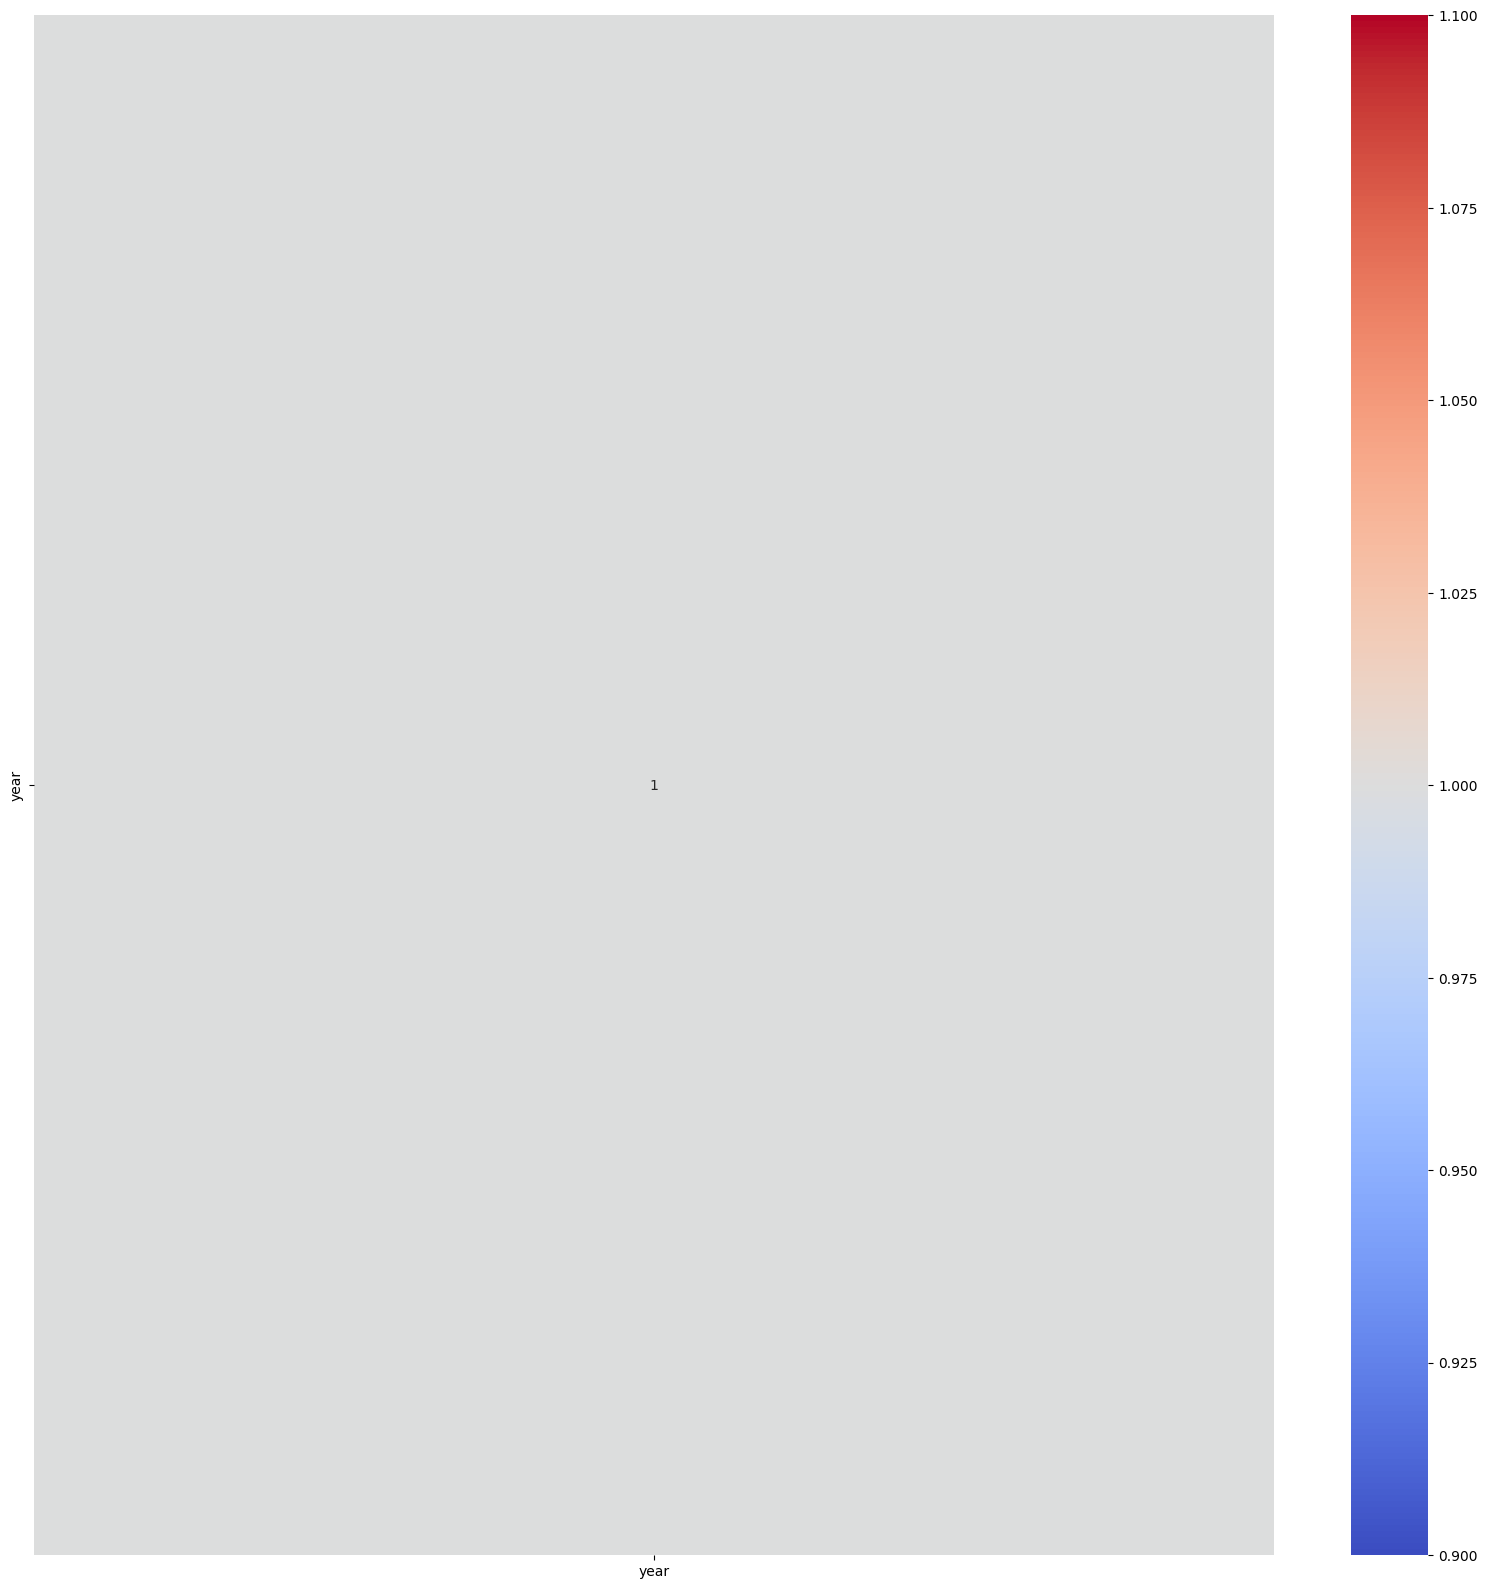

Series([], dtype: float64)
    year
0      1
1      2
2      3
3      4
4      6
..   ...
90     7
91     7
92     7
93     7
94     7

[86 rows x 1 columns]
coaches_df


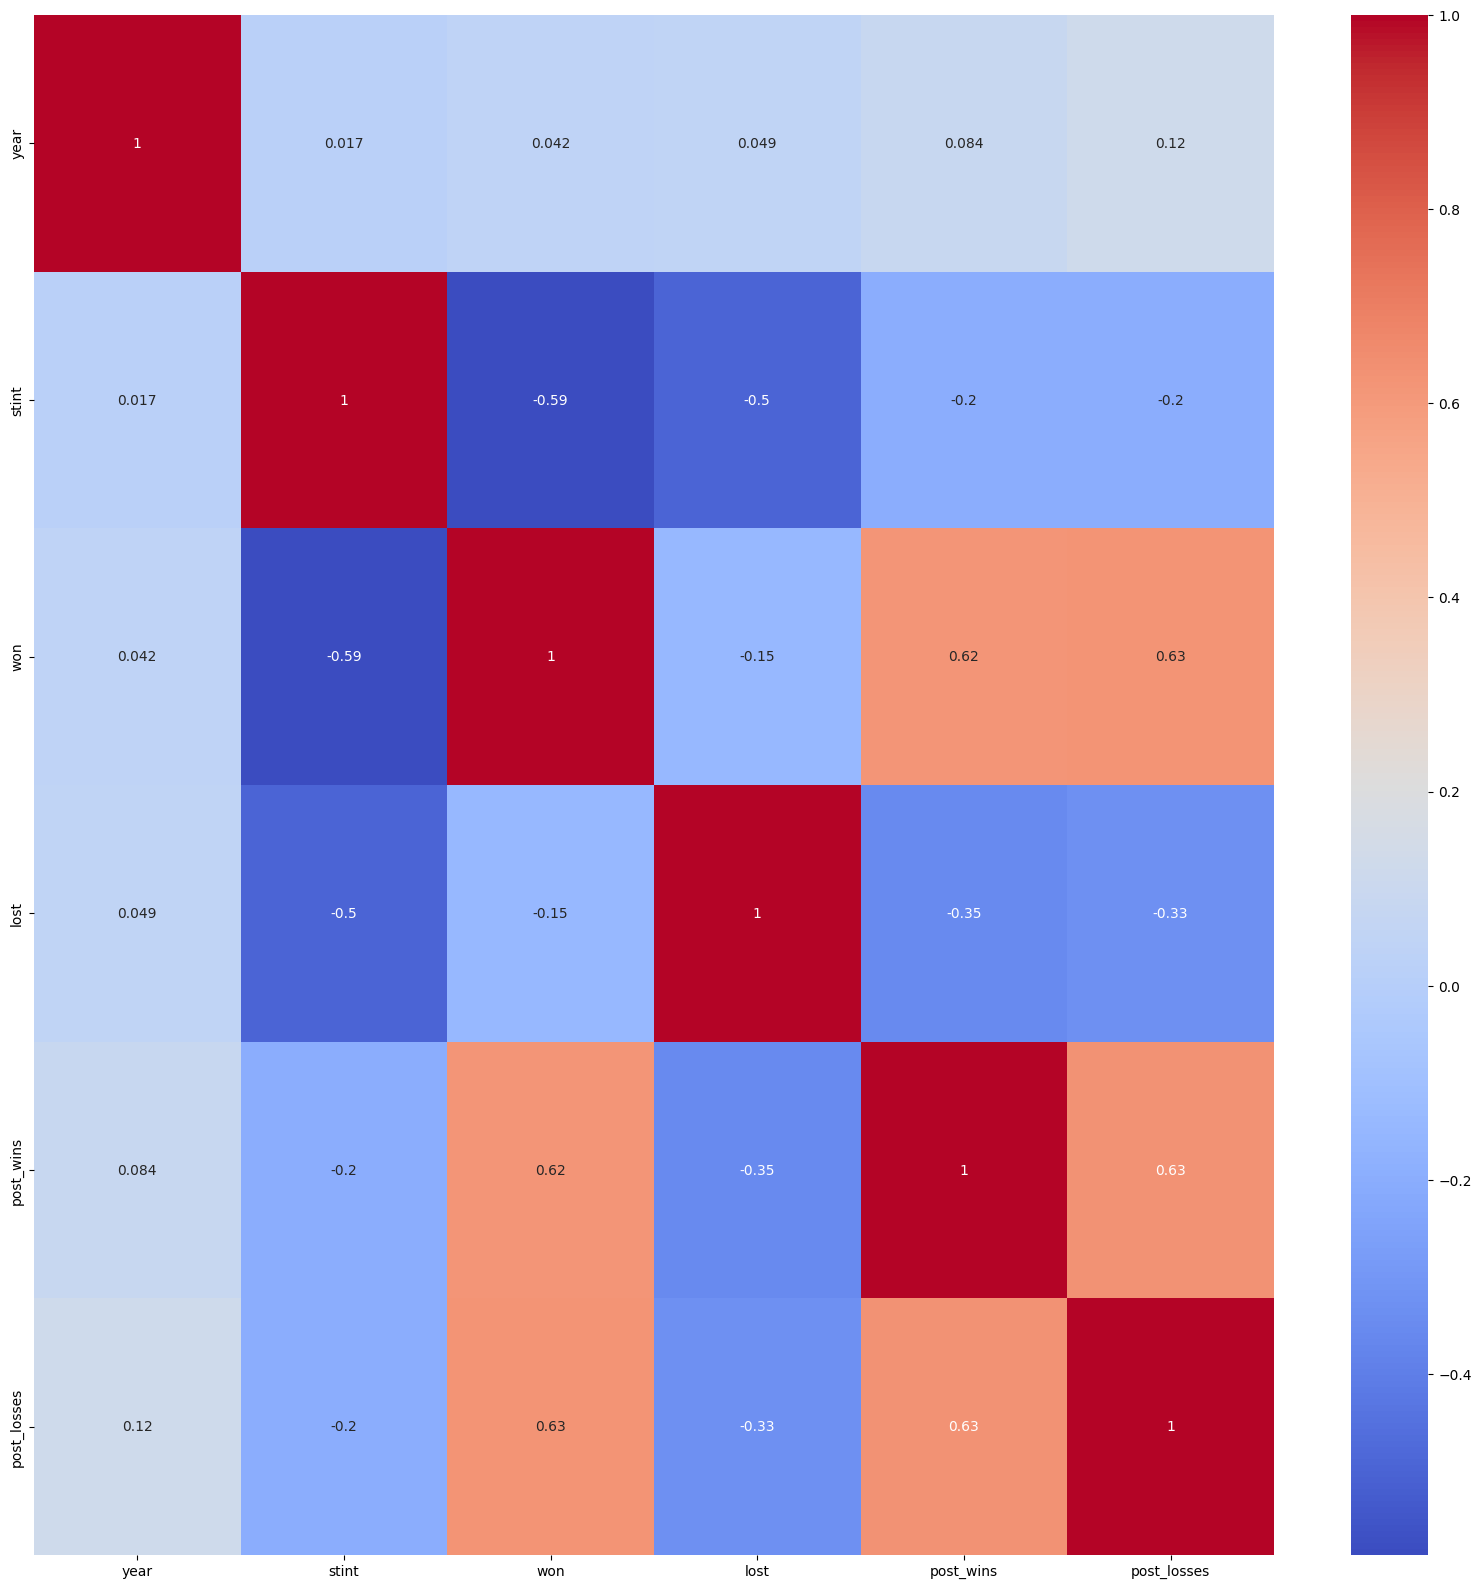

Series([], dtype: float64)
     year  stint  won  lost  post_wins  post_losses
0       5      0   17    17          1            2
1       1      0   20    12          4            3
2       2      0   21    11          3            3
3       3      0   18    14          4            4
4       4      0   16    18          0            0
..    ...    ...  ...   ...        ...          ...
157     6      0   21    13          2            2
158     7      0   21    13          0            2
159     8      0   21    13          3            3
160     8      0   10    24          0            0
161     9      0   16    18          0            0

[162 rows x 6 columns]
players_df


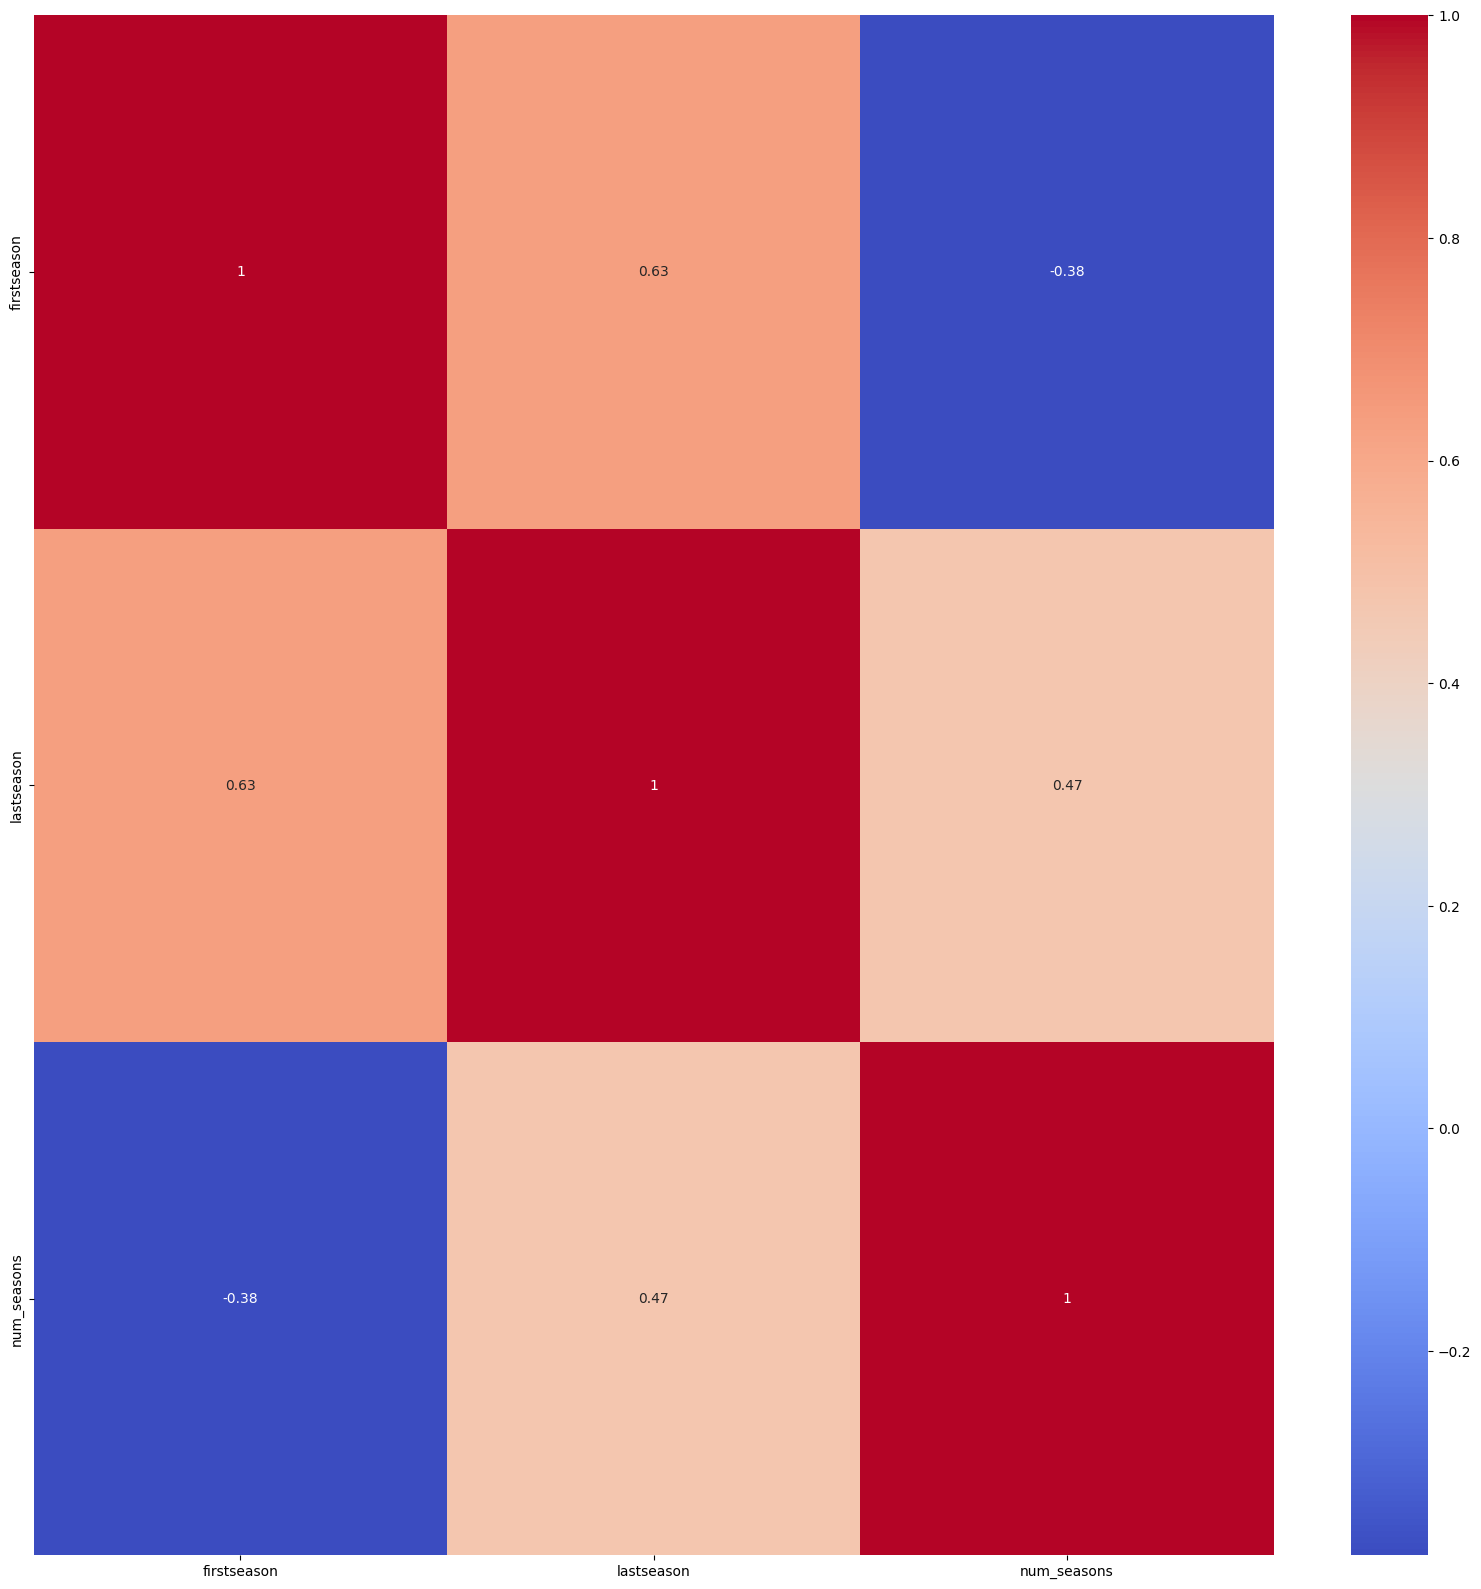

Series([], dtype: float64)
     firstseason  lastseason  num_seasons
1              2           9            8
4              4           4            1
8              3           3            1
9              9          10            2
11             1           2            2
..           ...         ...          ...
886            1           3            3
887            6           6            1
888           10          10            1
891            4           4            1
892            9           9            1

[555 rows x 3 columns]
players_teams_df


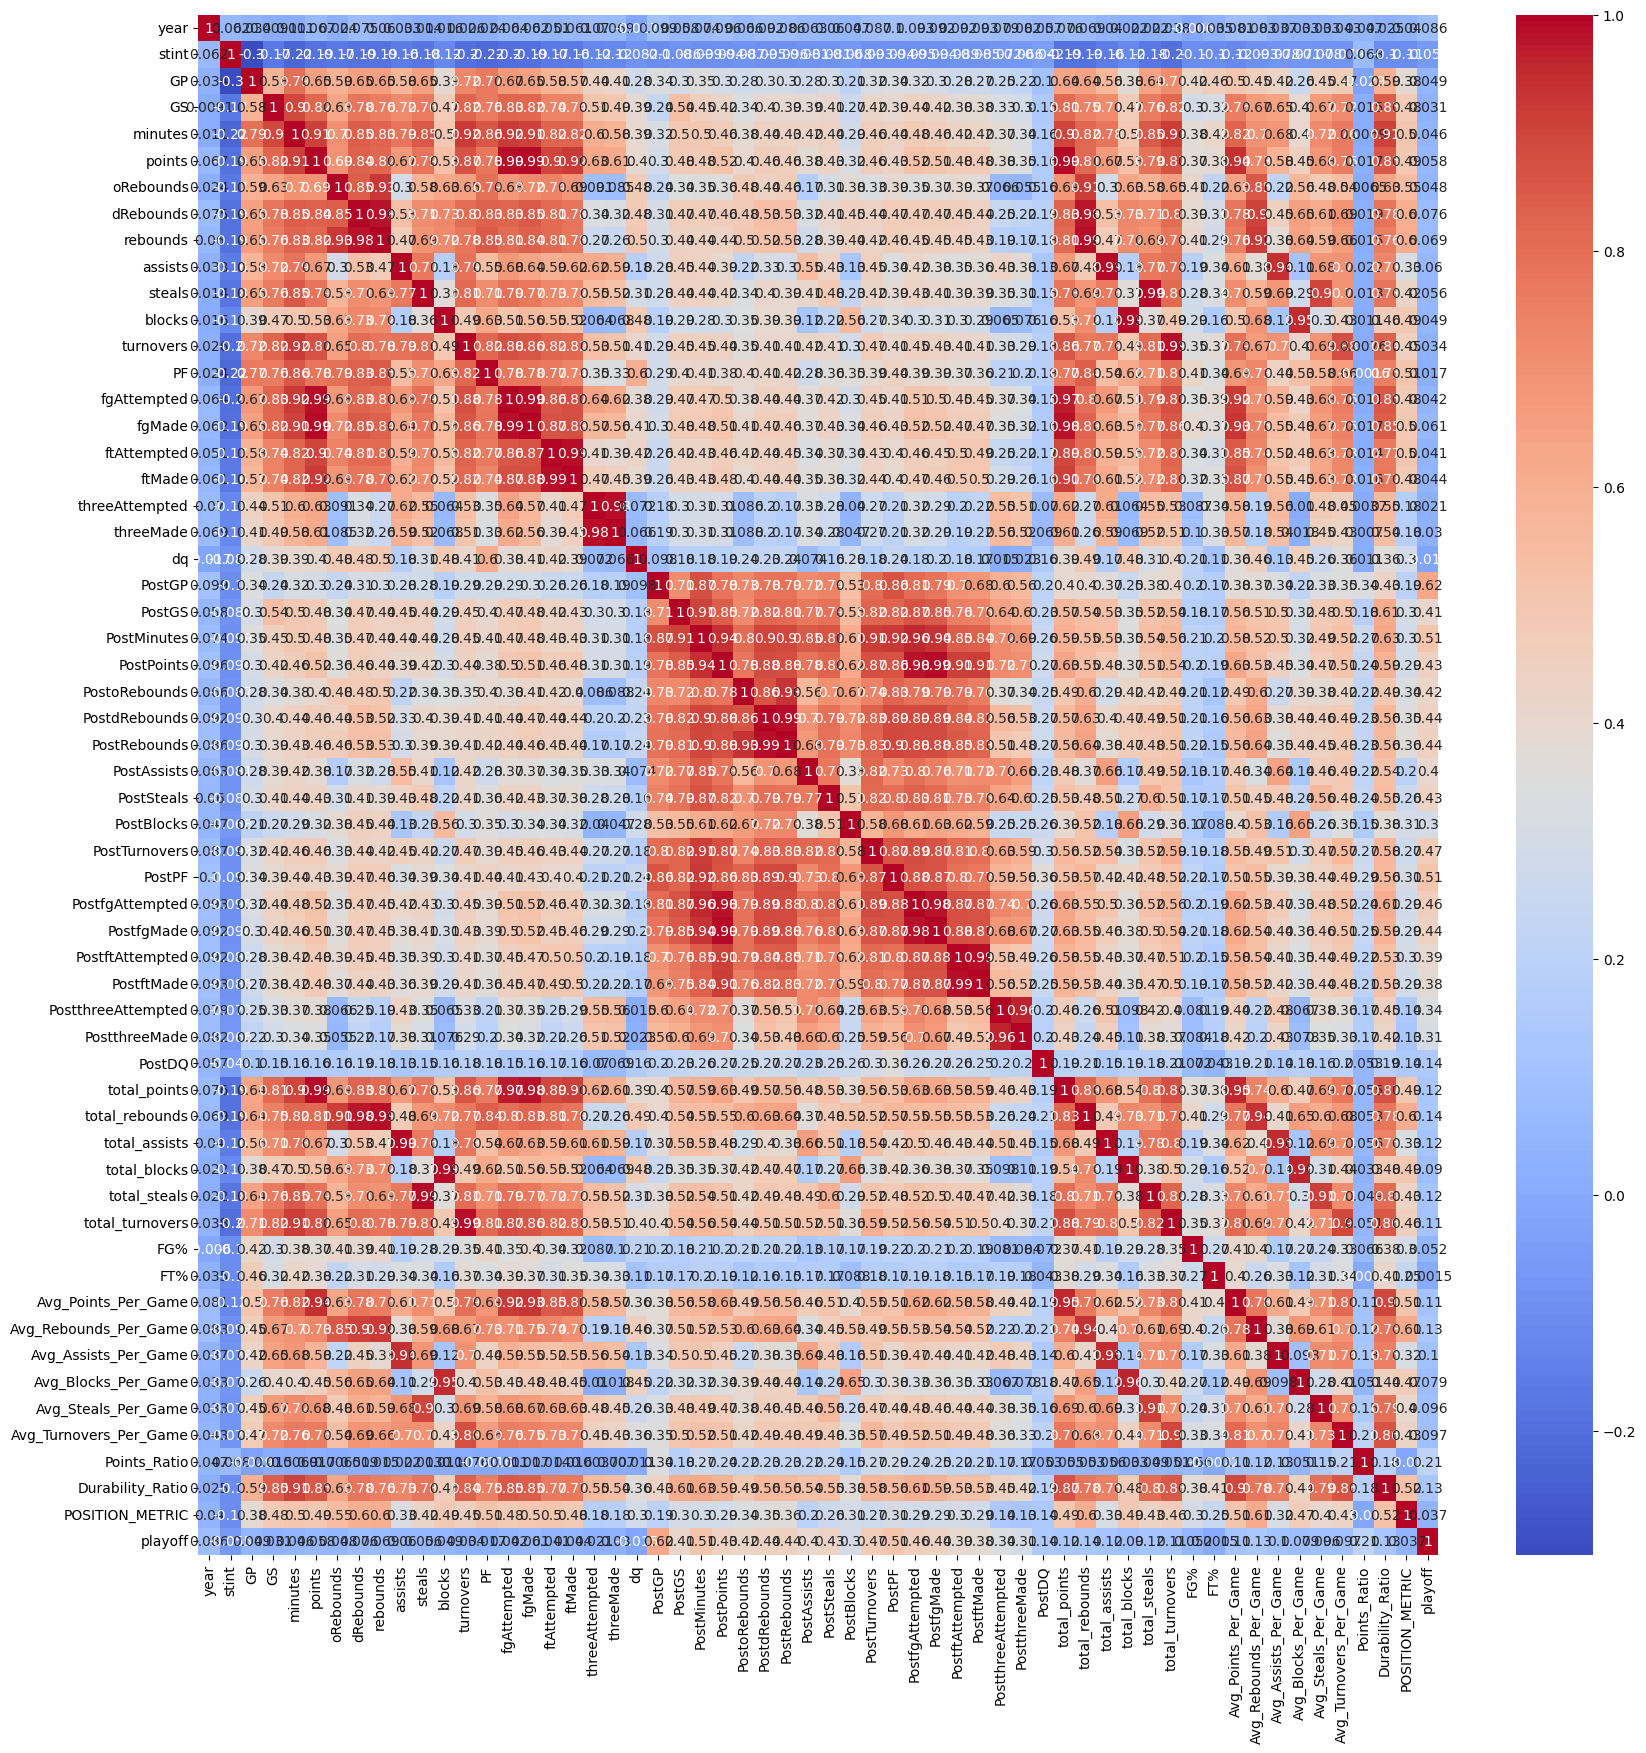

PostfgMade        PostPoints         0.992409
total_blocks      blocks             0.991859
total_assists     assists            0.991080
points            fgMade             0.990684
total_steals      steals             0.990570
                                       ...   
turnovers         dRebounds          0.802589
PostTurnovers     PostGP             0.802462
Durability_Ratio  total_steals       0.802228
PostfgAttempted   PostAssists        0.801153
total_assists     total_turnovers    0.800142
Length: 184, dtype: float64
      year  stint  GP  threeMade  dq  PostBlocks  PostthreeMade  PostDQ  \
0        2      0  26         19   2           0              0       0   
1        3      0  27         20   0           0              0       0   
2        4      0  30         25   0           1              3       0   
3        5      0  22         20   0           2              2       0   
4        6      0  31         33   0           0              0       0   
...    ...    ..

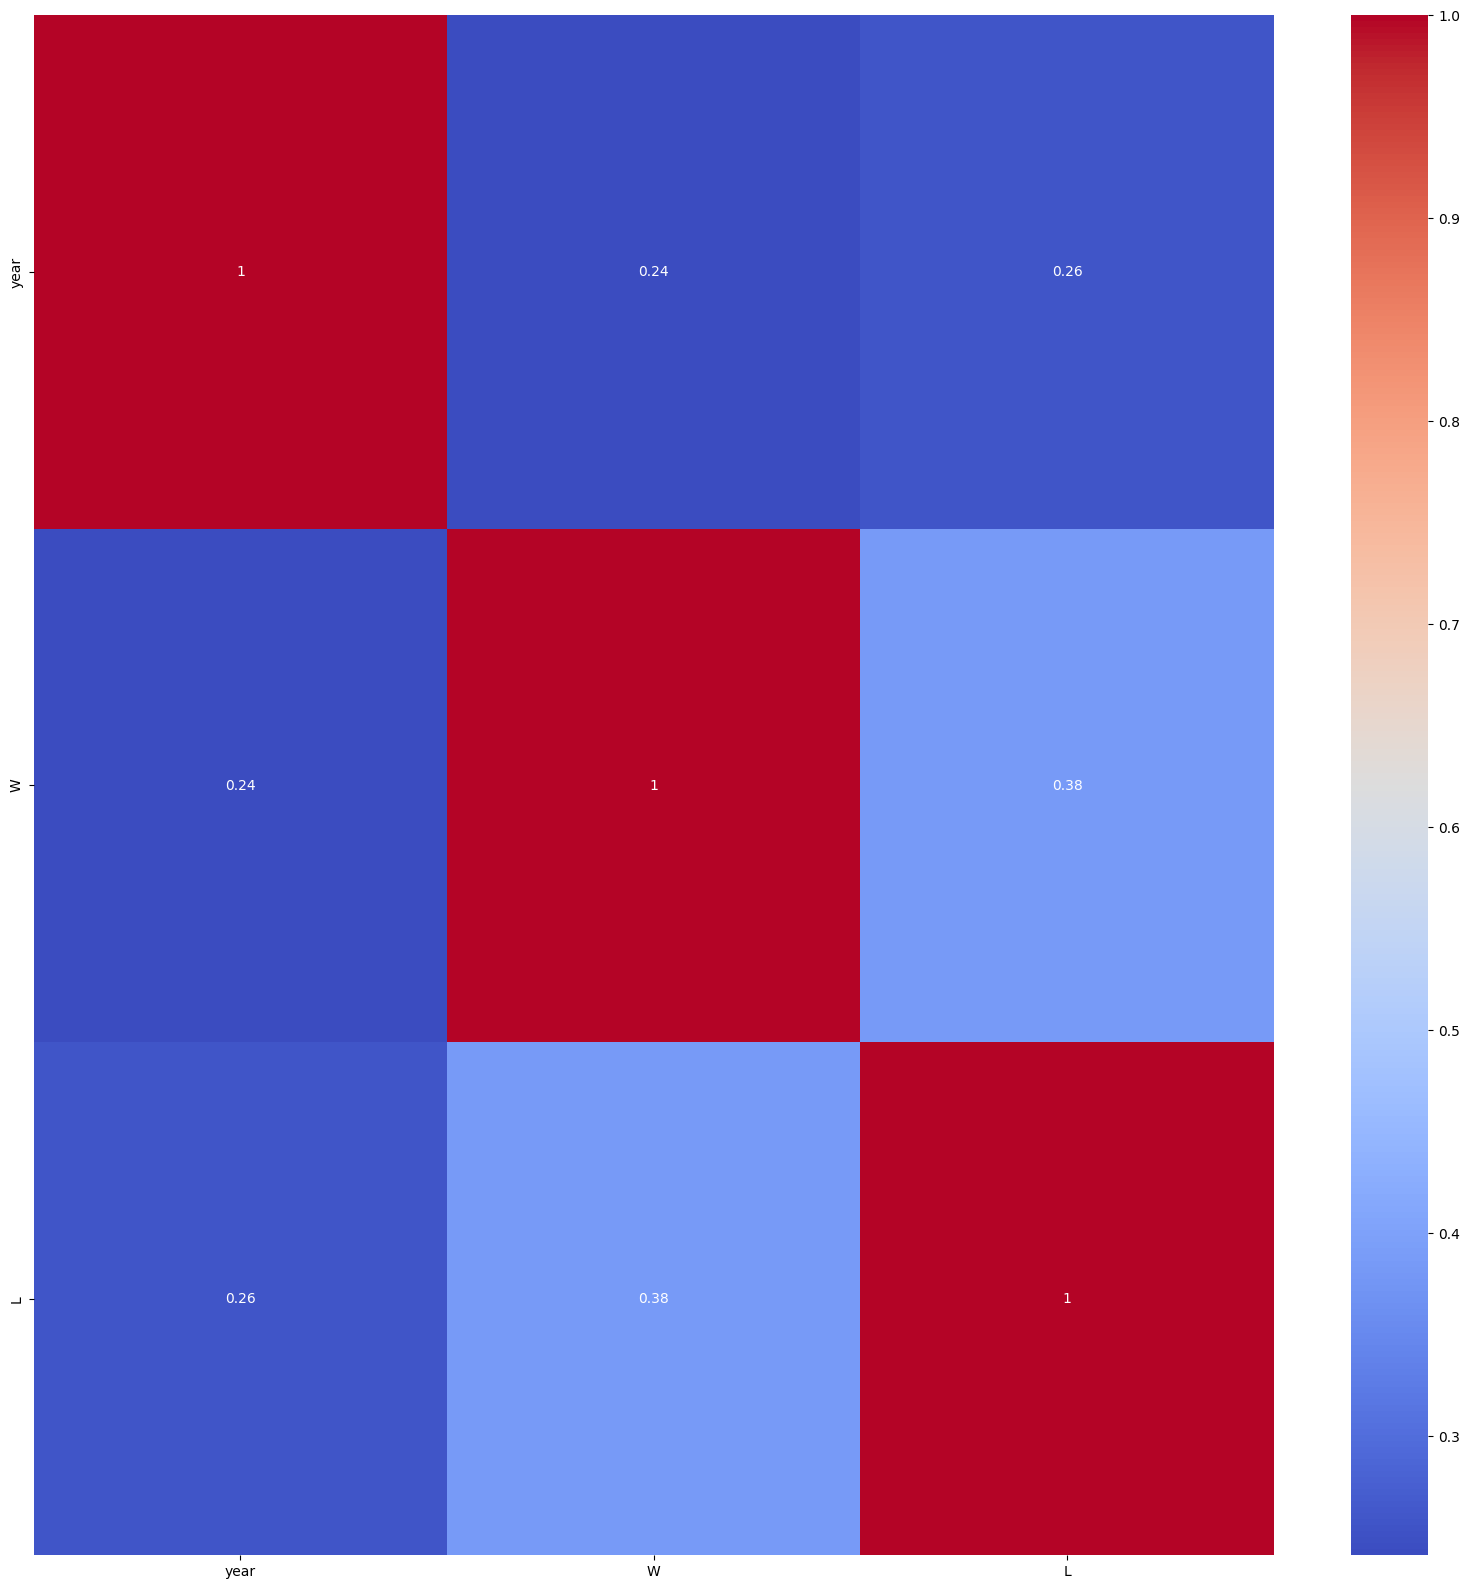

Series([], dtype: float64)
    year  W  L
0      1  2  1
1      1  2  0
2      1  2  0
3      1  2  0
4      1  2  0
..   ... .. ..
65    10  2  0
66    10  2  0
67    10  2  1
68    10  2  1
69    10  3  2

[70 rows x 3 columns]
teams_df


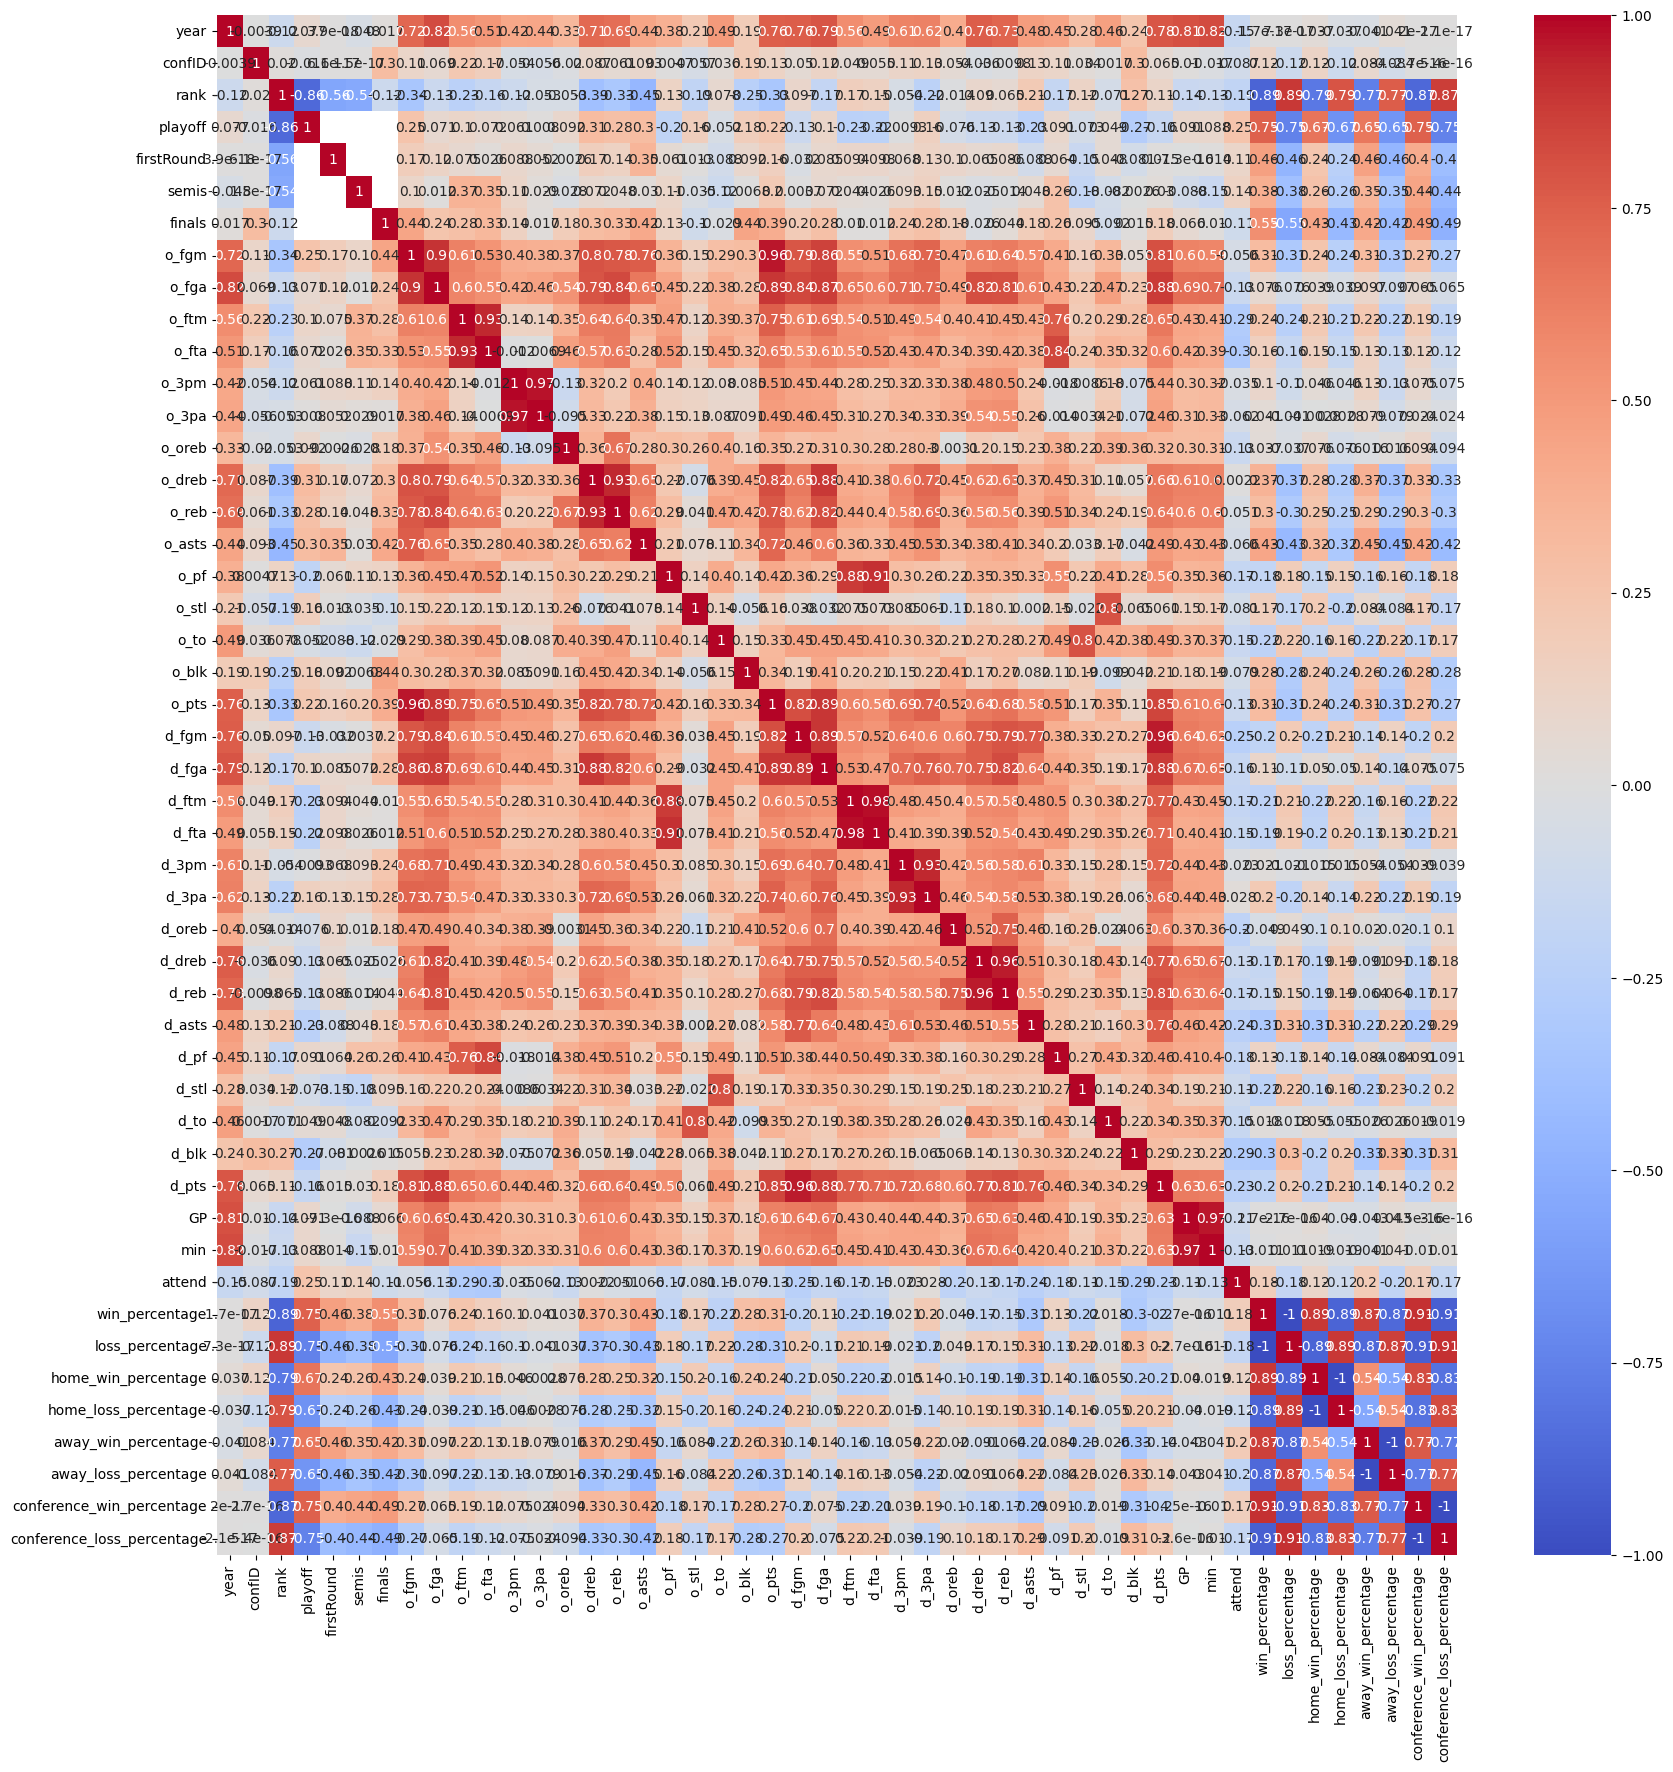

d_ftm                       d_fta                         0.979640
o_3pm                       o_3pa                         0.970076
GP                          min                           0.967510
o_pts                       o_fgm                         0.964508
d_pts                       d_fgm                         0.958903
d_dreb                      d_reb                         0.957760
d_3pa                       d_3pm                         0.934678
o_fta                       o_ftm                         0.933098
o_dreb                      o_reb                         0.931034
conference_loss_percentage  loss_percentage               0.911133
conference_win_percentage   win_percentage                0.911133
d_fta                       o_pf                          0.906362
o_fga                       o_fgm                         0.900705
o_pts                       o_fga                         0.894379
                            d_fga                         0.89

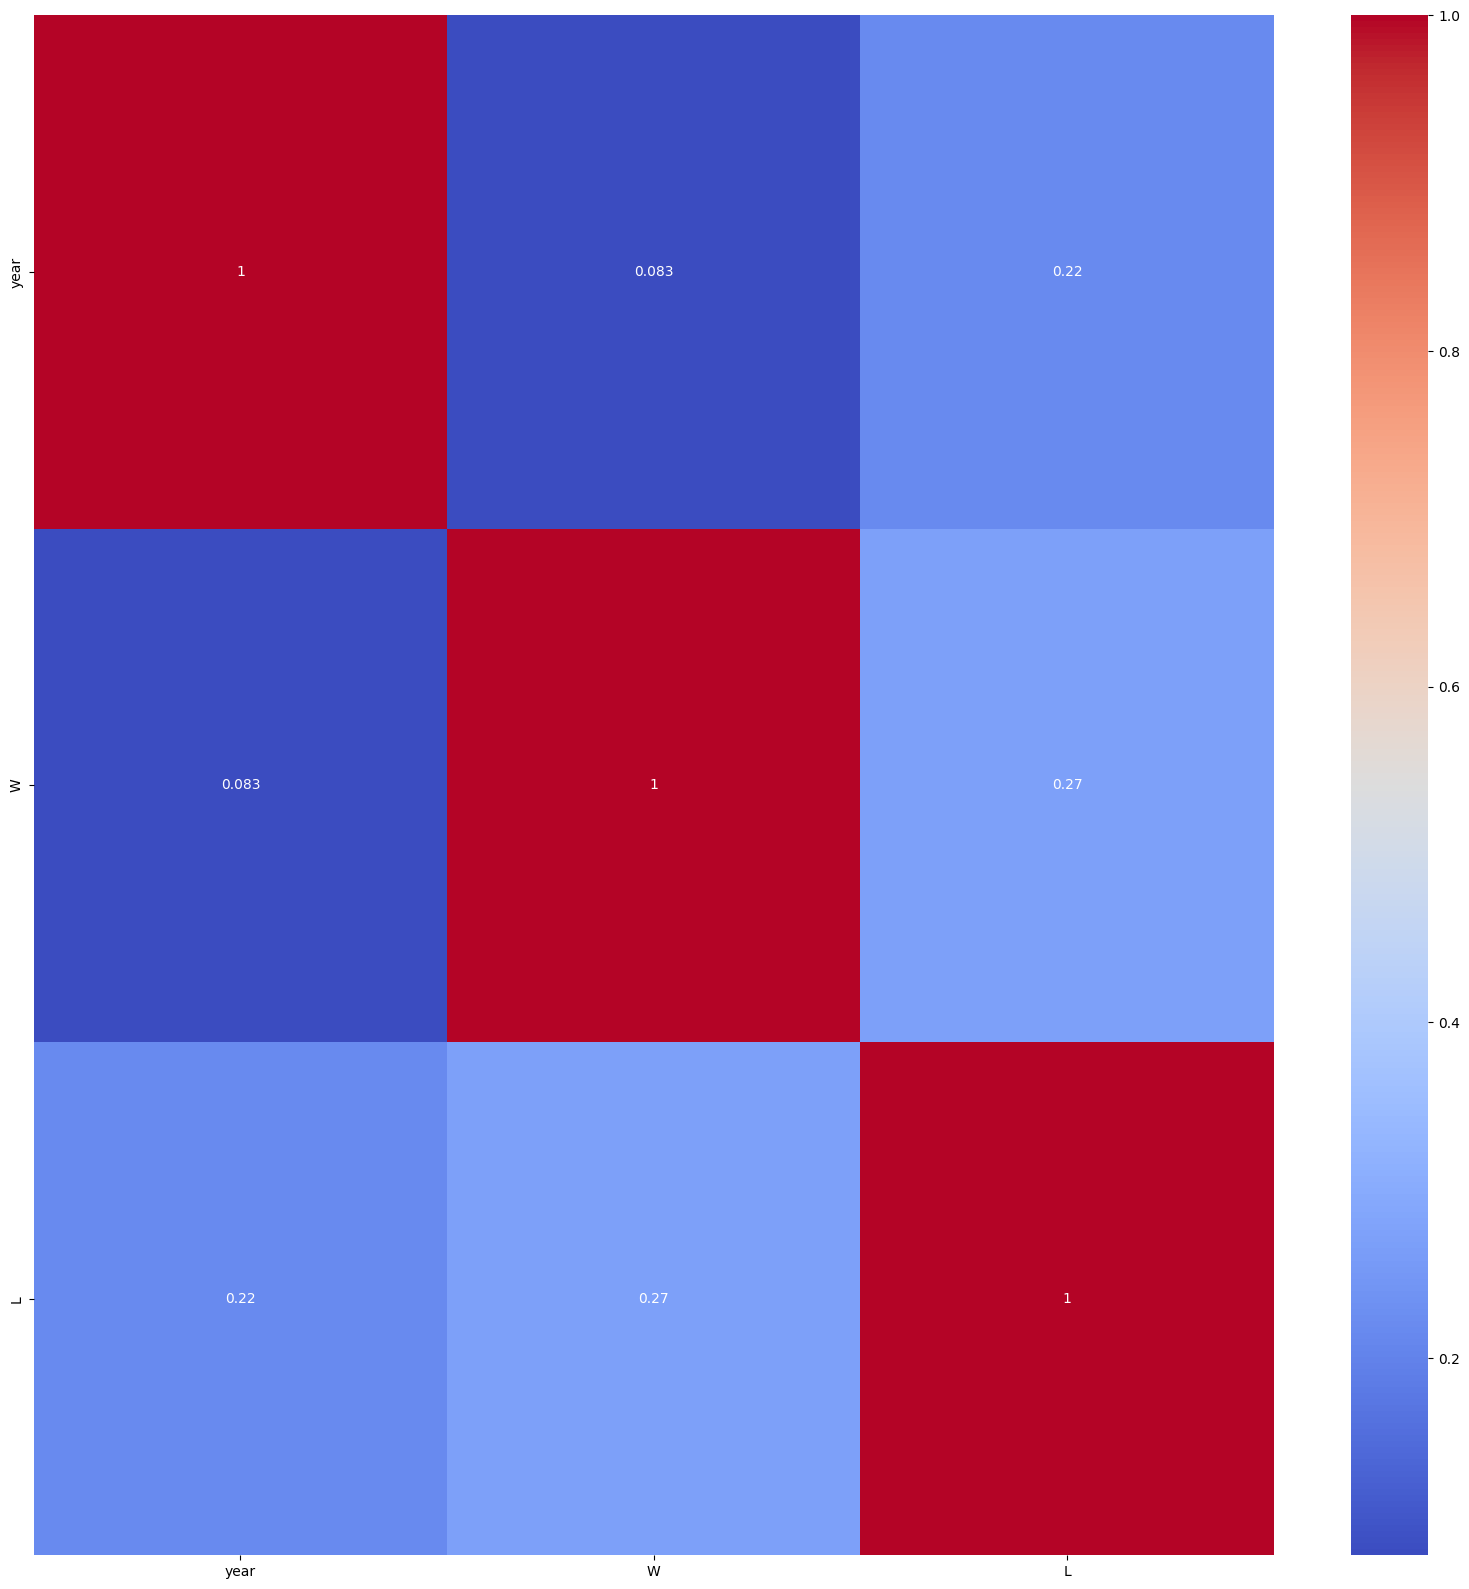

Series([], dtype: float64)
    year  W  L
0      1  6  0
1      1  1  2
2      1  3  3
3      1  0  2
4      1  4  3
..   ... .. ..
75    10  1  2
76    10  7  4
77    10  1  2
78    10  3  3
79    10  0  2

[80 rows x 3 columns]


In [19]:
for df in dfs:
    print(df)
    if 'players_teams_df' in df:
        dfs[df] = went_to_playoff(dfs[df], dfs)
    #select only the numerical columns
    new_df = delete_most_correlated(dfs[df].select_dtypes(include=np.number))
    #merge new_df with the categorical columns
    print(new_df)
    dfs[df] = new_df.merge(dfs[df].select_dtypes(exclude=np.number), left_index=True, right_index=True)

### Remove categorical variables 

There are several categorical variables that we will remove from the model, as they do not add any value to the model.

In [20]:
#remove categorical columns from team_df that are not needed 
#franchID, name, arena

dfs['teams_df'] = dfs['teams_df'].drop(columns=['name', 'arena'])

Some teams changed their names, but they maintained the same Franchise ID. We will map the teams to their Franchise ID and replace the team ID with the Franchise ID.

In [21]:

# Iterate over each row in the DataFrame
def franchise_mapping(teams_df, dfs):
    team_franchise_mapping = {}
    for index, row in teams_df.iterrows():
        # Extract team and franchise IDs from the current row
        team_id = row['tmID']
        franchise_id = row['franchID']

        # Check if the team ID is not already in the mapping dictionary
        if team_id not in team_franchise_mapping:
            # Add the team ID and its corresponding franchise ID to the mapping
            team_franchise_mapping[team_id] = franchise_id

    # Now, team_franchise_mapping contains the mapping between team IDs and franchise IDs
    print(team_franchise_mapping)

    for df_name, df in dfs.items():
        # Check if 'tmID' is a column in the current DataFrame
        if 'tmID' in df.columns:
            # Replace team IDs with franchise IDs using the mapping
            df['tmID'] = df['tmID'].map(team_franchise_mapping)
        if 'franchID' in df.columns:
            # Drop the 'franchID' column
            df.drop(columns=['franchID'], inplace=True)
        
franchise_mapping(dfs['teams_df'], dfs)

{'ATL': 'ATL', 'CHA': 'CHA', 'CHI': 'CHI', 'CLE': 'CLE', 'CON': 'CON', 'DET': 'DET', 'HOU': 'HOU', 'IND': 'IND', 'LAS': 'LAS', 'MIA': 'MIA', 'MIN': 'MIN', 'NYL': 'NYL', 'ORL': 'CON', 'PHO': 'PHO', 'POR': 'POR', 'SAC': 'SAC', 'SAS': 'SAS', 'SEA': 'SEA', 'UTA': 'SAS', 'WAS': 'WAS'}


### Saving the data

In [22]:
#saving the tables in a csv file, inside the prep_data folder
for df in dfs:
    dfs[df].to_csv('../prep_data/' + df + '.csv', index=False)

### Normalization and Standardization

In [23]:
# for the numeric columns in players_teams_df verify if they follow gaussian distribution
from scipy import stats
for col in dfs['teams_df'].select_dtypes(include=np.number).columns:
    # Check if the column has 'NA' values
    if 'NA' in dfs['teams_df'][col].unique():
        print(f"Skipping {col} due to 'NA' values")
        continue

    # Evaluate if the column follows a Gaussian distribution
    statistics, p_value = stats.shapiro(dfs['teams_df'][col].dropna())  # Drop 'NA' values for the test
    alpha = 0.05
    if p_value > alpha:
        print('{} follows a Gaussian distribution'.format(col))
    else:
        print('{} does not follow a Gaussian distribution'.format(col))


year does not follow a Gaussian distribution
confID does not follow a Gaussian distribution
playoff does not follow a Gaussian distribution
firstRound does not follow a Gaussian distribution
semis does not follow a Gaussian distribution
finals does not follow a Gaussian distribution
o_fta follows a Gaussian distribution
o_3pm follows a Gaussian distribution
o_oreb follows a Gaussian distribution
o_asts follows a Gaussian distribution
o_stl follows a Gaussian distribution
o_to does not follow a Gaussian distribution
o_blk does not follow a Gaussian distribution
d_3pa does not follow a Gaussian distribution
d_oreb does not follow a Gaussian distribution
d_dreb does not follow a Gaussian distribution
d_asts follows a Gaussian distribution
d_stl follows a Gaussian distribution
d_to follows a Gaussian distribution
d_blk follows a Gaussian distribution
attend does not follow a Gaussian distribution


There are no Gaussian distributions in the numeric columns of the players_teams_df, so we will only apply linear normalizations between 0 and 1.
But there are such cases in the teams_df. NOT YET NORMALIZED 

In [24]:
# for the numeric columns in players_teams_df apply linear normalization between 0 and 1
for col in dfs['teams_df'].select_dtypes(include=np.number).columns:
    if col not in ['year', 'confID', 'playoff', 'firstRound', 'semis', 'finals']:
        aux = (dfs['teams_df'][col] - dfs['teams_df'][col].min()) / (dfs['teams_df'][col].max() - dfs['teams_df'][col].min())
        dfs['teams_df'][col] = aux.round(3)
# store in csv in prep_data with 2 appended to the name
# dfs['teams_df'].to_csv('../prep_data/teams_df2.csv', index=False)
    

## Merge information into a single table


Insights on merging tables:
- teams with teams_post, some values are NaN when the team didn't participate in the playoffs
- players with players_teams, some values are NaN when the player didn't participate in any team, remove such cases?
- awards with players
- number of trophies won by each team in each season

- more ideas...
- create a score for each player's performance in each season and then aggregate it to the team's performance in each season?
- Is series_post relevant?

In [25]:
teams_post_df = dfs['teams_post_df'].rename(columns={'W': 'W_post', 'L': 'L_post'})
dfs['teams_df'] = dfs['teams_df'].merge(teams_post_df, on=['tmID', 'year'], how='left')

dfs['teams_df'].head()

# to csv
# dfs['teams_df'].to_csv('teams_df_merge_with_post.csv', index=False)

,year,confID,playoff,firstRound,semis,finals,o_fta,o_3pm,o_oreb,o_asts,...,d_oreb,d_dreb,d_asts,d_stl,d_to,d_blk,attend,tmID,W_post,L_post
0,9,0,0,<NA>,<NA>,<NA>,0.620,0.633,0.467,0.348,...,0.753,0.786,1.000,0.753,0.660,0.467,0.415,ATL,NaN,NaN
1,10,0,1,0,<NA>,<NA>,0.692,0.235,0.771,0.536,...,0.483,0.672,0.767,1.000,0.815,0.459,0.313,ATL,0.0,2.0
2,1,0,0,<NA>,<NA>,<NA>,0.262,0.312,0.300,0.549,...,0.331,0.257,0.703,0.413,0.139,0.385,0.165,CHA,NaN,NaN
3,2,0,1,1,1,0,0.143,0.412,0.319,0.263,...,0.433,0.000,0.186,0.400,0.220,0.393,0.238,CHA,4.0,4.0
4,3,0,1,0,<NA>,<NA>,0.470,0.674,0.286,0.362,...,0.157,0.140,0.341,0.073,0.131,0.237,0.243,CHA,0.0,2.0


In [26]:
# join players (bioID) with players_teams (playerID)
players_teams_df  = dfs['players_teams_df'].rename(columns={'playerID': 'bioID'})
players_teams_df = dfs['players_df'].merge(players_teams_df, on=['bioID', 'pos'], how='right')
players_teams_df = players_teams_df.rename(columns={'bioID': 'playerID'})

# to csv
dfs['players_teams_df'].to_csv('../prep_data/players_df_merge_with_players_teams.csv', index=False)

In [27]:
# Assuming you have already imported players_df and teams_df
teams_df3 = dfs['teams_df'].copy()

# Iterate over each column in players_df
numeric_columns = dfs['players_teams_df'].select_dtypes(include=np.number).columns
exclude_columns = {'year', 'tmID', 'lgID', 'playerID', 'firstseason', 'lastseason', 'playoff', 'num_seasons', 'stint', 'GP', 'threeMade', 'dq', 'PostBlocks', 'PostthreeMade', 'PostDQ'}
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

for col in numeric_columns:
    # Calculate the weighted mean using 'minutes' as weights within the groupby operation
    weighted_mean = dfs['players_teams_df'].groupby(['year', 'tmID', 'playoff'])[col].apply(lambda x: np.average(x, weights=dfs['players_teams_df'].loc[x.index, 'Durability_Ratio'])).reset_index(name=col + '_weighted_mean')

    # Merge the weighted mean into teams_df3
    teams_df3 = teams_df3.merge(weighted_mean, on=['year', 'tmID', 'playoff'], how='left')
    # teams_df3[col + '_weighted_mean'] = teams_df3[col].fillna(weighted_mean)  # Fill missing values with the overall weighted mean

# Save the DataFrame to CSV
# dfs['teams_df'] = teams_df3.copy()
teams_df3.to_csv('../prep_data/teams_df3.csv', index=False)

teams_df3.head()

,year,confID,playoff,firstRound,semis,finals,o_fta,o_3pm,o_oreb,o_asts,...,tmID,W_post,L_post,total_blocks_weighted_mean,FG%_weighted_mean,FT%_weighted_mean,Avg_Rebounds_Per_Game_weighted_mean,Points_Ratio_weighted_mean,Durability_Ratio_weighted_mean,POSITION_METRIC_weighted_mean
0,9,0,0,<NA>,<NA>,<NA>,0.620,0.633,0.467,0.348,...,ATL,NaN,NaN,8.890518,0.399134,0.734591,3.393223,0.000000,0.437410,0.356415
1,10,0,1,0,<NA>,<NA>,0.692,0.235,0.771,0.536,...,ATL,0.0,2.0,11.766427,0.432184,0.751582,3.955611,0.074171,0.472803,0.389593
2,1,0,0,<NA>,<NA>,<NA>,0.262,0.312,0.300,0.549,...,CHA,NaN,NaN,9.369808,0.421597,0.758900,3.275276,0.000000,0.495548,0.348043
3,2,0,1,1,1,0,0.143,0.412,0.319,0.263,...,CHA,4.0,4.0,15.232162,0.405002,0.773482,4.189252,0.221987,0.643048,0.346073
4,3,0,1,0,<NA>,<NA>,0.470,0.674,0.286,0.362,...,CHA,0.0,2.0,10.900030,0.397007,0.712230,3.593056,0.042843,0.531965,0.317742


In [28]:
#do similarly but now instead of the average of each player's performance, calculate the sum of the 3 best players' performance
teams_df4 = dfs['teams_df'].copy()
for col in players_teams_df:
    col_type = players_teams_df[col].dtype
    if col_type == 'float64' or col_type == 'int64' and col not in {'year', 'tmID', 'lgID', 'playerID', 'firstseason', 'lastseason', 'playoff', 'num_seasons', 'stint', 'GP', 'threeMade', 'dq', 'PostBlocks', 'PostthreeMade', 'PostDQ'}:
        # Group by ['year', 'tmID', 'playoff'], sum the 3 largest values for each group
        grouped = players_teams_df.groupby(['year', 'tmID', 'playoff'])[col].apply(lambda x: x.nlargest(3).sum())
        
        # Rename the grouped column to indicate it represents the sum of the 3 best players' performance
        col_name_sum = f'{col}_sum_top3'
        grouped = grouped.reset_index().rename(columns={col: col_name_sum})
        
        # Merge the sum into teams_df4 with a specified suffix
        teams_df4 = pd.merge(teams_df4, grouped, on=['year', 'tmID', 'playoff'], how='left', suffixes=('', f'_{col_name_sum}'))



dfs['teams_df'] = teams_df4.copy()
teams_df4.to_csv('../prep_data/teams_df4.csv', index=False)

teams_df4.head()

,year,confID,playoff,firstRound,semis,finals,o_fta,o_3pm,o_oreb,o_asts,...,tmID,W_post,L_post,total_blocks_sum_top3,FG%_sum_top3,FT%_sum_top3,Avg_Rebounds_Per_Game_sum_top3,Points_Ratio_sum_top3,Durability_Ratio_sum_top3,POSITION_METRIC_sum_top3
0,9,0,0,<NA>,<NA>,<NA>,0.620,0.633,0.467,0.348,...,ATL,NaN,NaN,61,1.479050,2.668632,16.795455,0.000000,1.689148,1.847218
1,10,0,1,0,<NA>,<NA>,0.692,0.235,0.771,0.536,...,ATL,0.0,2.0,87,1.508883,2.561405,21.764706,0.897288,1.804265,1.831397
2,1,0,0,<NA>,<NA>,<NA>,0.262,0.312,0.300,0.549,...,CHA,NaN,NaN,64,1.469393,2.735521,14.833333,0.000000,2.041059,1.898997
3,2,0,1,1,1,0,0.143,0.412,0.319,0.263,...,CHA,4.0,4.0,92,1.477005,2.650813,17.001078,0.896412,2.598958,1.729288
4,3,0,1,0,<NA>,<NA>,0.470,0.674,0.286,0.362,...,CHA,0.0,2.0,68,1.553566,2.586687,16.375000,0.213689,2.067057,1.258249


In [29]:
# Number of trophies won by players on each team
teams_df5 = teams_df3.copy()

# Merge awards_players and player_teams_df to get team information for each award
players_teams_df = dfs['awards_players_df'].merge(players_teams_df, on=['playerID', 'year'], how='left')

# Group by team_id and count the number of awards per team
team_trophies_count = players_teams_df.groupby(['tmID', 'year'])['award'].count().reset_index()
team_trophies_count.rename(columns={'award': 'num_trophies'}, inplace=True)

teams_df5 = teams_df5.merge(team_trophies_count, on=['tmID', 'year'], how='left')

teams_df5['num_trophies'] = teams_df5['num_trophies'].replace([np.inf, -np.inf, np.NaN], 0)

dfs['teams_df'] = teams_df5.copy()
teams_df5.to_csv('../prep_data/prepared_dataset.csv', index=False)

teams_df5.head()

,year,confID,playoff,firstRound,semis,finals,o_fta,o_3pm,o_oreb,o_asts,...,W_post,L_post,total_blocks_weighted_mean,FG%_weighted_mean,FT%_weighted_mean,Avg_Rebounds_Per_Game_weighted_mean,Points_Ratio_weighted_mean,Durability_Ratio_weighted_mean,POSITION_METRIC_weighted_mean,num_trophies
0,9,0,0,<NA>,<NA>,<NA>,0.620,0.633,0.467,0.348,...,NaN,NaN,8.890518,0.399134,0.734591,3.393223,0.000000,0.437410,0.356415,0.0
1,10,0,1,0,<NA>,<NA>,0.692,0.235,0.771,0.536,...,0.0,2.0,11.766427,0.432184,0.751582,3.955611,0.074171,0.472803,0.389593,1.0
2,1,0,0,<NA>,<NA>,<NA>,0.262,0.312,0.300,0.549,...,NaN,NaN,9.369808,0.421597,0.758900,3.275276,0.000000,0.495548,0.348043,0.0
3,2,0,1,1,1,0,0.143,0.412,0.319,0.263,...,4.0,4.0,15.232162,0.405002,0.773482,4.189252,0.221987,0.643048,0.346073,0.0
4,3,0,1,0,<NA>,<NA>,0.470,0.674,0.286,0.362,...,0.0,2.0,10.900030,0.397007,0.712230,3.593056,0.042843,0.531965,0.317742,0.0


Retrieve data from competition year before going to modeling

In [30]:
schema = config["db_11_schema"]

SELECT = "SELECT * FROM " + schema + "." # + table_name 
coaches = fetch(SELECT + "coaches") # all coaches who've managed the teams during the time period,
players_teams = fetch(SELECT + "players_teams") # performance of each player for each team they played,
teams = fetch(SELECT + "teams") # performance of the teams for each season,

players_teams_11_df = pd.DataFrame(players_teams, columns=['playerID', 'year', 'stint', 'tmID', 'lgID'])
teams_11_df = pd.DataFrame(teams, columns=['year', 'lgID', 'tmID', 'franchID', 'confID', 'name', 'arena', 'playoff'])
coaches_11_df = pd.DataFrame(coaches, columns=['coachID', 'year', 'tmID', 'lgID', 'stint'])

In [31]:
teams_11_df.columns

Index(['year', 'lgID', 'tmID', 'franchID', 'confID', 'name', 'arena',
       'playoff'],
      dtype='object')

In [32]:
binary_columns = ['confID', 'playoff']

for col in binary_columns:
    teams_11_df[col] = teams_11_df[col].replace('EA', 0)
    teams_11_df[col] = teams_11_df[col].replace('WE', 1)
    teams_11_df[col] = teams_11_df[col].replace('N', 0)
    teams_11_df[col] = teams_11_df[col].replace('Y',1)

franchise_mapping(teams_11_df, {'teams': teams_11_df, 'players_teams': players_teams_11_df, 'coaches':coaches_11_df})

players_teams_11_df = players_teams_11_df.reindex(columns=dfs["players_teams_df"].columns)
dfs["players_teams_df"] = pd.concat([dfs["players_teams_df"], players_teams_11_df])

teams_11_df = teams_11_df.reindex(columns=dfs["teams_df"].columns)
dfs["teams_df"] = pd.concat([dfs["teams_df"], teams_11_df])

coaches_11_df = coaches_11_df.reindex(columns=dfs["coaches_df"].columns)
dfs["coaches_df"] = pd.concat([dfs["coaches_df"], coaches_11_df])

{'SEA': 'SEA', 'WAS': 'WAS', 'LAS': 'LAS', 'MIN': 'MIN', 'PHO': 'PHO', 'SAS': 'SAS', 'TUL': 'DET', 'ATL': 'ATL', 'CHI': 'CHI', 'CON': 'CON', 'IND': 'IND', 'NYL': 'NYL'}


In [33]:
dfs["teams_df"].columns

Index(['year', 'confID', 'playoff', 'firstRound', 'semis', 'finals', 'o_fta',
       'o_3pm', 'o_oreb', 'o_asts', 'o_stl', 'o_to', 'o_blk', 'd_3pa',
       'd_oreb', 'd_dreb', 'd_asts', 'd_stl', 'd_to', 'd_blk', 'attend',
       'tmID', 'W_post', 'L_post', 'total_blocks_weighted_mean',
       'FG%_weighted_mean', 'FT%_weighted_mean',
       'Avg_Rebounds_Per_Game_weighted_mean', 'Points_Ratio_weighted_mean',
       'Durability_Ratio_weighted_mean', 'POSITION_METRIC_weighted_mean',
       'num_trophies'],
      dtype='object')

In [34]:
test_year = 11
num_previous_years = test_year - 1  # Number of previous years to consider
pd.set_option('display.max_columns', None)

def weighted_mean(arr):
    num_years = len(arr)
    weights = np.arange(1, num_years + 1 ) * 1.0 / 10
    return np.sum(arr * weights) / np.sum(weights)

def weighted_average(arr, weights):
    if len(arr) != len(weights):
        raise ValueError("Array and weights must have the same length")
    return np.sum(arr * weights) / np.sum(weights)

for i in range(1, num_previous_years + 1):

    # Sort the players_teams DataFrame by player ID and season
    players_teams_sorted = dfs["players_teams_df"].sort_values(by=['playerID', 'year'], ascending=True)
    # players_teams_sorted.to_csv('../prep_data/rolling_window/debug.csv', index=False)

    numeric_columns = players_teams_sorted.select_dtypes(include='number').columns.difference(['year', 'stint', 'playoff'])

    for col in numeric_columns:
        players_teams_sorted[col] = (
            players_teams_sorted.groupby('playerID')[col]
            .rolling(window=i, min_periods=1, closed='left')
            .apply(weighted_mean, raw=False)
            .reset_index(0, drop=True)
        )

    # Group by 'teamId' and 'year' and aggregate the cumulative statistics (Weighted average by time of play of previous years)
    team_players_year_stats = (
        players_teams_sorted.groupby(['tmID', 'year'])
        .apply(lambda x: pd.Series({
            col: weighted_average(x[col], x['Durability_Ratio']) for col in numeric_columns
        })).reset_index()
    )

    # Apply the same to team stats
    teams_sorted = dfs["teams_df"].sort_values(by=['tmID', 'year'], ascending=True)
    teams_sorted = teams_sorted.drop(columns=['total_blocks_weighted_mean',
       'FG%_weighted_mean', 'FT%_weighted_mean',
       'Avg_Rebounds_Per_Game_weighted_mean', 'Points_Ratio_weighted_mean',
       'Durability_Ratio_weighted_mean', 'POSITION_METRIC_weighted_mean'])

    numeric_columns = teams_sorted.select_dtypes(include='number').columns.difference(['year', 'confID', 'playoff'])

    for col in numeric_columns:
        teams_sorted[col] = (
            teams_sorted.groupby('tmID')[col]
            .rolling(window=i, min_periods=1, closed='left')
            .apply(weighted_mean, raw=False)
            .reset_index(0, drop=True)
        )

    # If first appearance of team on wnba, fill the stats with the average of the other rows
    # Calculate the mean of each numeric column
    average_numeric = teams_sorted.select_dtypes(include=np.number).mean()

    # Fill NaN values in numeric columns with their means
    teams_sorted.loc[:, teams_sorted.dtypes == np.number] = teams_sorted.loc[:, teams_sorted.dtypes == np.number].fillna(average_numeric)


    df = teams_sorted.merge(team_players_year_stats, on=['tmID', 'year'], how='left', suffixes=('', f'_{i}'))

    df = df[df['year'] != 1]
    df = df.round(2)

    df.to_csv('../prep_data/rolling_window/data_with_' + str(i) + '_years_in_the_past.csv', index=False)

In [ ]:
connection.close()